# Zadatak 1 (Novčići)

Analizom datog skupa slika, uocavamo da su pozadina i objekti (novcici) na slikama karakteristicne nijanse (sa par izuzetaka; na primer 7. slika u kojoj je pozadina malo savijena). Prvo cemo detektovati polozaje novica pomocu funkcije coin_mask. Izlaz ove funkcije ce nam koristiti za labeliranje slike u regione. Zatim cemo odrediti povrsine regiona i klasifikovati ih u dve klase: objekti manej povrsine (novcici od 1 din) i objekti vece povrsine (novcici od 5din). U nastavku slede realizacije potrebnih funkcija.

In [1]:
# Importovanje potrebnih biblioteka 
import scipy
from pylab import *

import skimage
from skimage import *
from skimage.color import *
from skimage.exposure import *
from skimage.filters import *
from skimage import io
from skimage.feature import peak_local_max, canny
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter, disk
from skimage import morphology

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fitz  # PyMuPDF
from sklearn.cluster import KMeans
import cv2
import os

## 1.1 Binarna maska za novcice: analiza problema

Prilikom detekcije novcica, nekoliko ideja mi je padalo na pamet. 

Da bismo detektovali novcice, potrebno je nekoliko stvari da uzmemo u obzir. Za pocetak, svi nocici su krugovi. Zbog toga cemo za njihovu detekciju da koristimo Hafovu tranformaciju za detekciju krugova. Smatracemo da pozadina slike ima karakteristicnu nijansu i saturaciju. Ove osobine boje pozadine mozemo najbolje analizirati u HSV kolor sistemu. Na primeru druge slike iz skupa cemo prikazati HSV kolor sistem:

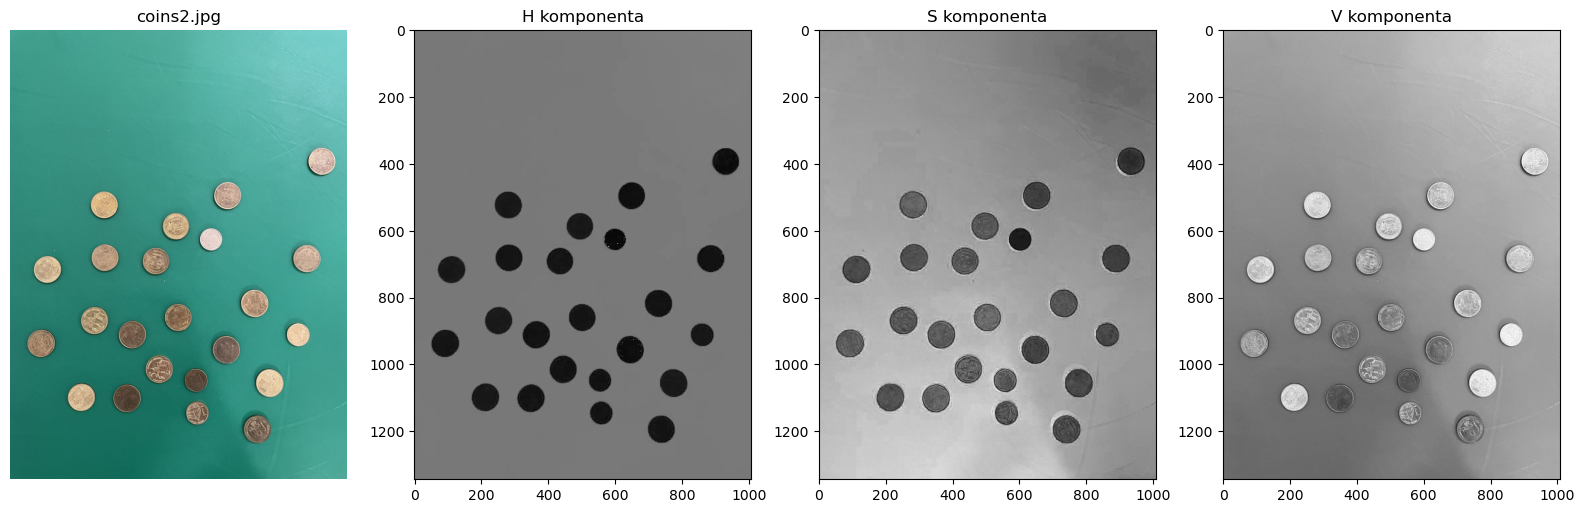

In [2]:
# Prikaz HSV kolor sistema nad jednom slikom iz dataset-a
img = skimage.img_as_float(imread('../sekvence/coins/coins2.jpg'));

img_hsv = color.rgb2hsv(img)
img_h = img_hsv[:,:,0]
img_s = img_hsv[:,:,1]
img_v = img_hsv[:,:,2]

plt.figure(figsize=(20,20));
plt.subplot(141); plt.imshow(img); plt.title('coins2.jpg'); plt.axis('off')
plt.subplot(142); plt.imshow(img_h, cmap='gray'); plt.title("H komponenta");
plt.subplot(143); plt.imshow(img_s, cmap='gray'); plt.title("S komponenta");
plt.subplot(144); plt.imshow(img_v, cmap='gray'); plt.title("V komponenta");

Uocavamo da je najveca razlika izmedju pozadine i objekata u **H komponenti** slike. Ovu komponentu cemo koristiti za potrebe detekcije. Posto cemo morati da detektujemo ivice, potrebno je da pozadina i objekti budu uniformniji. Zbog toga cemo filtrirati sliku **median filtrom**, da ne bi doslo do degradacije ivica! Nakon detekcije ivica, vrsimo **Hafovu transformaciju** i detektujemo krugove. Nakon Hafove transformacije cemo kreirati masku popunjavanjem krugova jedinicama, a pozadinu ostavljamo na nulama. Da bismo obezbedili da nam maska nema rupe, potrebno je izvrsiti morfoloske operacije **Dilatacije i erozije**. 

**Napomena o parametrima**: Parametri koje mozemo da podesavamo su sledeci: raspon i korak poluprecnika novcica, prag za detekciju ivice i minimalno rastojanje izmedju novcica. Birao sam ih tako da detekcija radi nad ulaznim slikama iz datog skupa. Konkretno, posto postoje slike u kojima ima puno novcica sa manjim sirinama u pikselima, a ima i slika sa malim brojem zumiranih novcica, raspon poluprecnika je sirok. Minimalno rastojanje sam birao na osnovu najblizih novcica u datom skupu slika. Ove parametre je moguce promeniti za potrebe nekih drugih slika, van datog skupa.

Sledi primer detekcije krugova sa međukoracima:

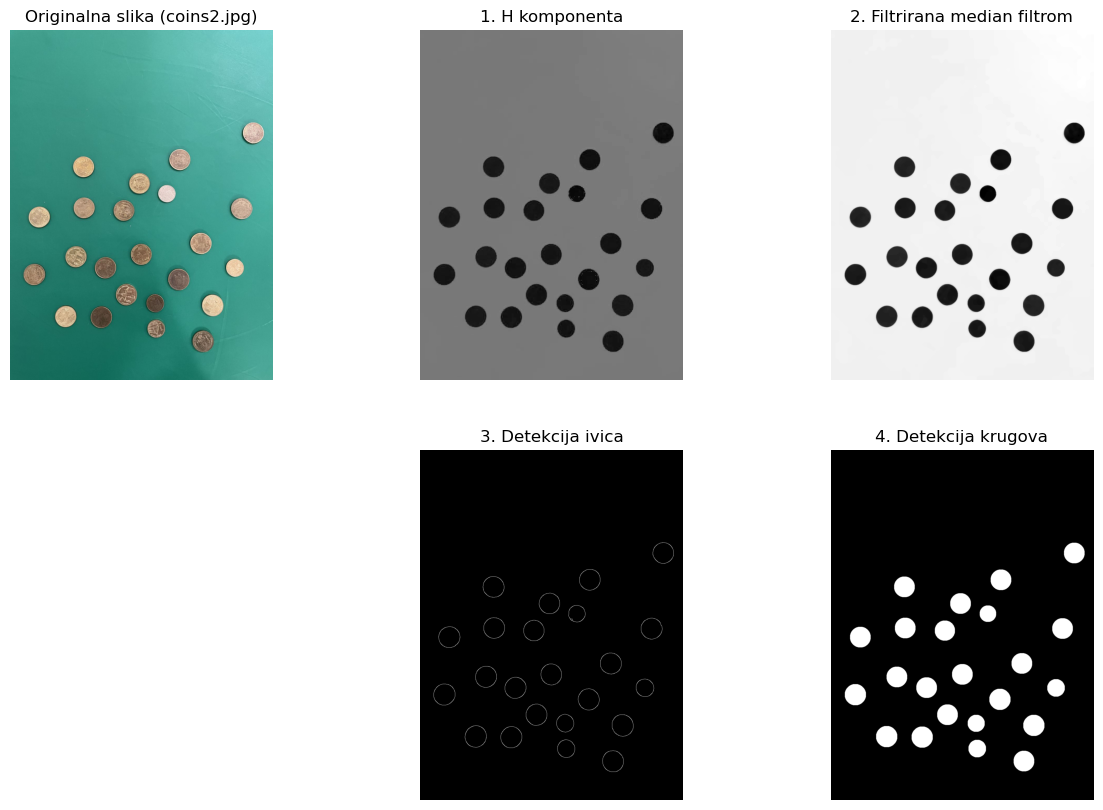

In [3]:
# Filtriranje median filtrom
image_med13x13 = scipy.ndimage.median_filter(img_h, size=(13,13), mode='reflect')

# Detekcija ivica
edges = canny(img_h, sigma=3)

# Opseg poluprecnika krugova koje detektujemo
radii = np.arange(20, 80, 1)

# Hafova transformacija za krugove
hough_res = hough_circle(edges, radii)
accums, cx, cy, radii = hough_circle_peaks(hough_res, radii, threshold=0.25, min_xdistance=30, min_ydistance=30)

# Kreiranje maske
coin_mask = np.zeros_like(img_h)
for center_y, center_x, radius in zip(cy, cx, radii):
    rr, cc = disk((center_y, center_x), radius)
    coin_mask[rr, cc] = 1

# Morfoloske operacije: DILATACIJA I EROZIJA
coin_mask = morphology.binary_closing(coin_mask, morphology.disk(3))

# Prikaz medjukoraka pri detekciji
plt.figure(figsize=(15,10))
plt.subplot(231); plt.imshow(img, cmap='gray'); plt.title('Originalna slika (coins2.jpg)'); plt.axis('off');
plt.subplot(232); plt.imshow(img_h, cmap='gray'); plt.title('1. H komponenta'); plt.axis('off');
plt.subplot(233); plt.imshow(image_med13x13, cmap='gray'); plt.title('2. Filtrirana median filtrom'); plt.axis('off');
plt.subplot(235); plt.imshow(edges, cmap='gray'); plt.title('3. Detekcija ivica'); plt.axis('off');
plt.subplot(236); plt.imshow(coin_mask, cmap='gray'); plt.title('4. Detekcija krugova'); plt.axis('off');

## 1.2. Binarna maska za novcice: realizacija funkcije

Funkciju realizujemo po gore opisanoj proceduri. Sledi njen kod:

In [4]:
def coin_mask(img_in):
    '''
    Kreira binarnu masku takvu da vrednost 1 imaju pikseli koji pripadaju novčićima, dok vrednost 0 ima ostatak slike
    
    Ulazi:
    - img_in (numpy.ndarray): Ulazna slika u boji
    
    Izlazi:
    - coin_mask (numpy.ndarray): Binarizovana maska sa detektovanim novcicima
    '''
    # Dohvatanje H komponente slike
    img_hsv = color.rgb2hsv(img_in)
    img_h = img_hsv[:,:,0]
    
    # Filtriranje median filtrom
    image_med13x13 = scipy.ndimage.median_filter(img_h, size=(13,13), mode='reflect')
    
    # Detekcija ivica
    edges = canny(img_h, sigma=3)
    
    # Opseg poluprecnika krugova koje detektujemo
    radii = np.arange(20, 80, 1)
    
    # Hafova transformacija za krugove
    hough_res = hough_circle(edges, radii)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, radii, threshold=0.25, min_xdistance=30, min_ydistance=30)

    # Kreiranje maske
    coin_mask = np.zeros_like(img_h)
    for center_y, center_x, radius in zip(cy, cx, radii):
        rr, cc = disk((center_y, center_x), radius)
        coin_mask[rr, cc] = 1

    # Morfoloske operacije: DILATACIJA I EROZIJA
    coin_mask = morphology.binary_closing(coin_mask, morphology.disk(3)) 
    
    return coin_mask

Zavrseno ucitavanje slika
Zavrseno 1
Zavrseno 2
Zavrseno 3
Zavrseno 4
Zavrseno 5
Zavrseno 6
Zavrseno 7
Zavrseno 8
Zavrseno 9


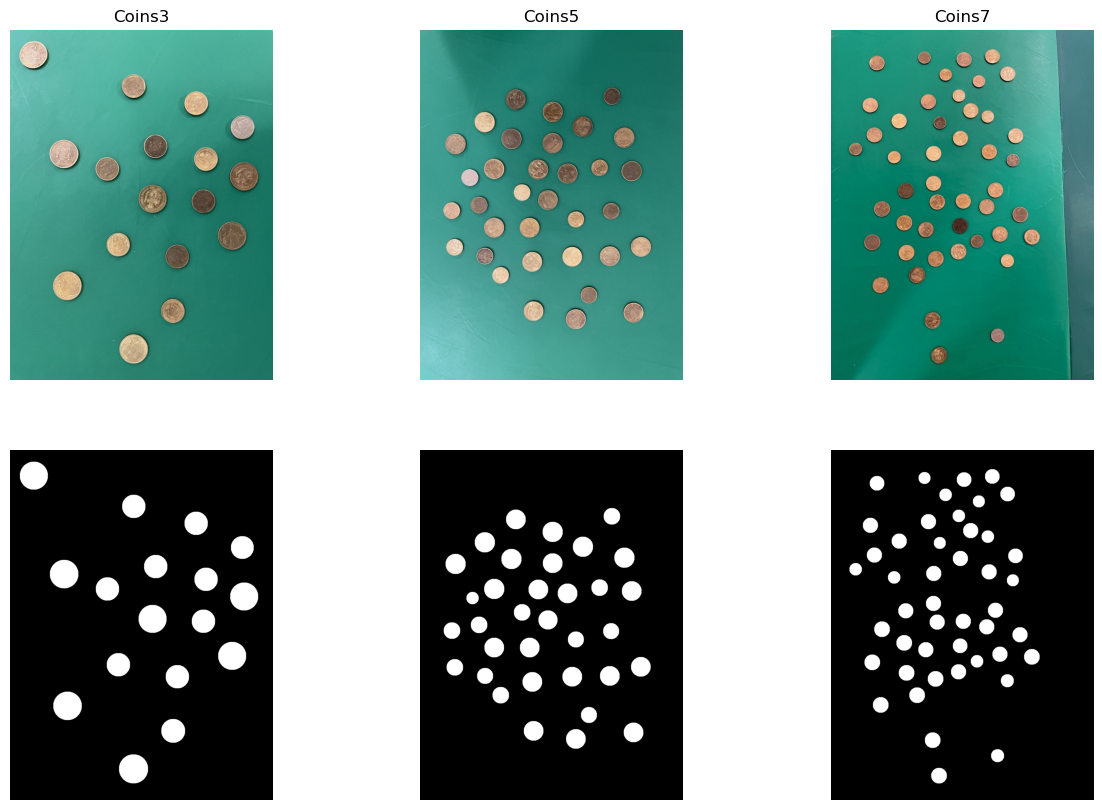

In [5]:
# Ucitavanje slika iz baze
img1 = skimage.img_as_float(imread('../sekvence/coins/coins1.jpg'));
img2 = skimage.img_as_float(imread('../sekvence/coins/coins2.jpg'));
img3 = skimage.img_as_float(imread('../sekvence/coins/coins3.jpg'));
img4 = skimage.img_as_float(imread('../sekvence/coins/coins4.jpg'));
img5 = skimage.img_as_float(imread('../sekvence/coins/coins5.jpg'));
img6 = skimage.img_as_float(imread('../sekvence/coins/coins6.jpg'));
img7 = skimage.img_as_float(imread('../sekvence/coins/coins7.jpg'));
img8 = skimage.img_as_float(imread('../sekvence/coins/coins8.jpg'));
img9 = skimage.img_as_float(imread('../sekvence/coins/coins9.jpg'));
print(f'Zavrseno ucitavanje slika')

# Vrsimo  funkciju nad slikama iz baze
coin_mask1 = coin_mask(img1)
print(f'Zavrseno 1')
coin_mask2 = coin_mask(img2)
print(f'Zavrseno 2')
coin_mask3 = coin_mask(img3)
print(f'Zavrseno 3')
coin_mask4 = coin_mask(img4)
print(f'Zavrseno 4')
coin_mask5 = coin_mask(img5)
print(f'Zavrseno 5')
coin_mask6 = coin_mask(img6)
print(f'Zavrseno 6')
coin_mask7 = coin_mask(img7)
print(f'Zavrseno 7')
coin_mask8 = coin_mask(img8)
print(f'Zavrseno 8')
coin_mask9 = coin_mask(img9)
print(f'Zavrseno 9')

# Prikaz medjukoraka za par slika
plt.figure(figsize=(15,10))
plt.subplot(231); plt.imshow(img3, cmap='gray'); plt.title('Coins3'); plt.axis('off');
plt.subplot(232); plt.imshow(img5, cmap='gray'); plt.title('Coins5'); plt.axis('off');
plt.subplot(233); plt.imshow(img7, cmap='gray'); plt.title('Coins7'); plt.axis('off');
plt.subplot(234); plt.imshow(coin_mask3, cmap='gray'); plt.axis('off');
plt.subplot(235); plt.imshow(coin_mask5, cmap='gray'); plt.axis('off');
plt.subplot(236); plt.imshow(coin_mask7, cmap='gray'); plt.axis('off');

## 1.3. Labeliranje

Na osnovu binarizovane maske, pronalazimo regione. Svaki region predstavlja novcic.

**Postupak:**

Koristimo postupak opisan na predavanjima, samo umesto 4-susedstva koristimo 8-susedstvo. Prolazimo kroz binarizovanu masku, odozgo na dole, s leva na desno. Za svaki beli piksel proveravamo njegovo 3 piksela: levi, gornji i gore-levi(dijagonalni). Razlikujemo 8 slučajeva u zavisnosti da li su ova 3 piksela bela ili crna. Adekvatno dodeljujemo trenutnom pikselu region na osnovu slučaja. Ukoliko je 2 ili više susedna piksela bela, potrebno je da sačuvamo ekvivalenciju regiona. 

Za ove potrebe imamo pomoćni niz **equivalence_list** i pomoćnu funkciju **add_equivalence**. Ideja je da svaki element ove liste bude jedan region finalne maske, a da element predstavlja listu regiona koje treba spojiti. Nakon prolaska kroz sve piksele, treba da prodjemo kroz ovu listu i da spojimo sve regione.

Nakon dodele regiona, bez spajanja, naše slike će imati preko 500 regiona. Zbog toga će ovaj proces spajanja trajati najduže u realizaciji klasifikacije novčića. Sledi realizacija funckije *bw_label* i njenih pomoćnih funkcija

In [6]:
# Pomocna funkcija za upisivanje ekvivalentnih regiona
def add_equivalence(equivalence_list, region1, region2):
    '''
    Dodaje par regiona (region1, region2) u listu ekvivalencija za kasnije spajanje regiona
    
    Ulazi:
    - equivalence_list (list): Lista do sad nadjenih ekvivalencija
    - region1 (int): Jedan od dva ekvivalentna regiona
    - region2 (int): Jedan od dva ekvivalentna regiona
    
    Izlazi:
    - equivalence_list (list): Lista sa dodatom ekvivalencijom
    '''
    # proveravamo da li se region1 nalazi u listi
    class_of_region1 = -1
    class_index = -1
    for class_list in equivalence_list:
        class_index = class_index + 1
        for element in class_list:
            if element == region1:
                class_of_region1 = class_index
                break
                
    # isto i za region2            
    class_of_region2 = -1
    class_index = -1
    for class_list in equivalence_list:
        class_index = class_index + 1
        for element in class_list:
            if element == region2:
                class_of_region2 = class_index
                break
    
    # Proveravamo da li oba regiona se ne nalaze u listi
    if class_of_region1 == -1 and class_of_region2 == -1:
        # U tom slucaju dodajemo novu listu u listu ekvivalencija sa ova 2 elementa
        equivalence_list.append([region1, region2])
        
    elif class_of_region1==-1:
        # Dodajemo region2 u listu sa indeksom class_of_region2
        equivalence_list[class_of_region2].append(region1)
        
    elif class_of_region2 == -1:
        equivalence_list[class_of_region1].append(region2)
    elif class_of_region1 != class_of_region2:
        # Spajamo ove dve liste
        equivalence_list[class_of_region1].extend(equivalence_list[class_of_region2])
        equivalence_list.remove(equivalence_list[class_of_region2])
        
    return equivalence_list

In [7]:
def label_mask(coin_mask):
    '''
    Funkcija labelira sve bele piksele u slici regionom.
    
    Ulazi:
    - coin_mask (numpy.ndarray): Binarizovana maska sa detektovanim novcicima
    
    Izlazi:
    - bw_img (numpy.ndarray): Labelirana slika sa regionima koji nisu spojeni
    - equivalence_list (list): Lista ekvivalentnih regiona 
    '''
    
    reg_num = 0 # Broj regiona
    equivalence_list = [] # Kasnije objasniti...   
    
    (N, M) = coin_mask.shape
    bw_img = np.zeros(coin_mask.shape)
    # Prolazimo kroz sve piksele binarizovane slike
    for i in range(N):
        for j in range(M):
            if coin_mask[i, j] == 1:
                # Ovom pikselu dodeljujemo vrednost
                # Proveravamo da li ima susede
                # Prvo edge case-ovi: kada je uz gornju ili levu ivicu slike
                if i==0 and j==0:
                    reg_num = reg_num + 1
                    bw_img[i, j] = reg_num
                    continue
                elif j==0: # Leva ivica, 
                    # Sigurno je i>0
                    if bw_img[i-1, j]!=0:
                        bw_img[i, j] = bw_img[i-1, j]
                    continue
                elif i==0: # Gornja ivica
                    # Sigurno je j>0
                    if bw_img[i, j-1]!=0:
                        bw_img[i, j] = bw_img[i, j-1]
                    continue

                # Resili smo edge case-ove
                region_levog = bw_img[i, j-1]
                region_dijagonalnog = bw_img[i-1, j-1]
                region_gornjeg = bw_img[i-1,j]

                # Razlikujemo 8 slucajeva 
                if region_levog==0 and region_gornjeg==0 and region_dijagonalnog==0:
                    # Dodeljujemo pikselu novu labelu
                    reg_num = reg_num + 1
                    bw_img[i, j] = reg_num

                elif region_gornjeg==0 and region_dijagonalnog==0:
                    # Levi piksel je deo novcica
                    bw_img[i, j] = region_levog

                elif region_gornjeg==0 and region_levog==0:
                    # Dijagonalni piksel je deo novcica
                    bw_img[i, j] = region_dijagonalnog

                elif region_levog==0 and region_dijagonalnog==0:
                    # Gornji piksel je deo novcica
                    bw_img[i, j] = region_gornjeg

                elif region_levog==0:
                    # Postavljamo labelu gornjeg piksela
                    bw_img[i, j] = region_gornjeg
                    # Provera da li su gornji i dijag. piksel u istom regionu
                    if region_gornjeg!=region_dijagonalnog:
                        # Ekvivalencija ova dva
                        equivalence_list = add_equivalence(equivalence_list, region_gornjeg, region_dijagonalnog)

                elif region_dijagonalnog==0:
                    # Postavljamo labelu levog piksela
                    bw_img[i, j] = region_levog
                    # Provera da li su gornji i levi piksel u istom regionu
                    if region_levog!=region_gornjeg:
                        # Ekvivalencija ova dva
                        equivalence_list = add_equivalence(equivalence_list, region_gornjeg, region_levog)

                elif region_gornjeg==0:
                    # Postavljamo labelu levog piksela
                    bw_img[i, j] = region_levog
                    # Provera da li su dijag. i levi piksel u istom regionu
                    if region_levog!=region_dijagonalnog:
                        # Ekvivalencija ova dva
                        equivalence_list = add_equivalence(equivalence_list, region_levog, region_dijagonalnog)
                else:
                    # Postavljamo labelu levog piksela
                    bw_img[i, j] = region_levog  
                    if region_levog!=region_dijagonalnog:
                        # Ekvivalencija ova dva
                        equivalence_list = add_equivalence(equivalence_list, region_levog, region_dijagonalnog)
                    if region_levog!=region_gornjeg:
                        # Ekvivalencija ova dva
                        equivalence_list = add_equivalence(equivalence_list, region_levog, region_gornjeg)  
    return bw_img, equivalence_list

In [8]:
def connect_equivalent_regions(labeled, equivalence_list):
    '''
    Funkcija koja spaja regione slike na osnovu liste ekvivalencija.
    
    Ulazi:
    - labeled (numpy.ndarray): Labelirana slika sa regionima koji nisu spojeni
    - equivalence_list (list): Lista ekvivalentnih regiona 
    
    Izlazi:
    - bw_img (numpy.ndarray): Labelirana slika sa spojenim regionima
    '''
    bw_img = np.zeros(labeled.shape)
    N, M = labeled.shape
    for i in range(N):
        # if i%100==0:
        #     print(f'Line: {i}')
        for j in range(M):
            for k in range(len(equivalence_list)):
                if labeled[i][j] in equivalence_list[k]:
                    bw_img[i][j] = k+1
    return bw_img

In [9]:
def bw_label(img_bin):
    '''
     Funkcija koja na osnovu binarne slike izdvojenih regiona od interesa pravi listu povezanih regiona i dodeljuje im labelu
     
     Ulazi:
     - img_bin (numpy.ndarray): Binarizovana slika (sa izdvojenim novčićima)
     
     Izlazi:
     - bw_img (numpy.ndarray): Slika sa labeliranim nepreklapajućim elementima. 
                        Pikseli elemenata imaju vrednost jednaku labeli elementa. Pikseli pozadine imaju vrednost 0.
    '''    
    labeled, equivalence_list = label_mask(img_bin)                       
    bw_img = connect_equivalent_regions(labeled, equivalence_list)
    return bw_img

## 1.4 Rad funkcije za labeliranje

Realizovali smo funkciju za nalaženje regiona. Sada ćemo je primeniti da prebrojimo broj novčića u slikama. Primetiti da će broj regiona u slici biti jednak maksimalnoj vrednosti piksela u izlazu preth. funkcije. Iz pdf-a priloženog sa domaćim i ulaznim slikama ćemo izdvojiti tabelu koja je priložena. Ove podatke ćemo zajedno sa brojem detektovanih regiona da prikažemo. Sledi izvršavanje prethodnih funkcija nad ulaznim slikama. 

**Komentar za medjukorake**

Primetiti da na colorbar-ovima da se razlikuju opsezi. U donjoj slici su regioni spojeni i zato je manji opseg vrednosti.

Image coins3.jpg over labeling
Image coins5.jpg over labeling
Image coins7.jpg over labeling
Image coins3.jpg over connecting
Image coins5.jpg over connecting
Image coins7.jpg over connecting


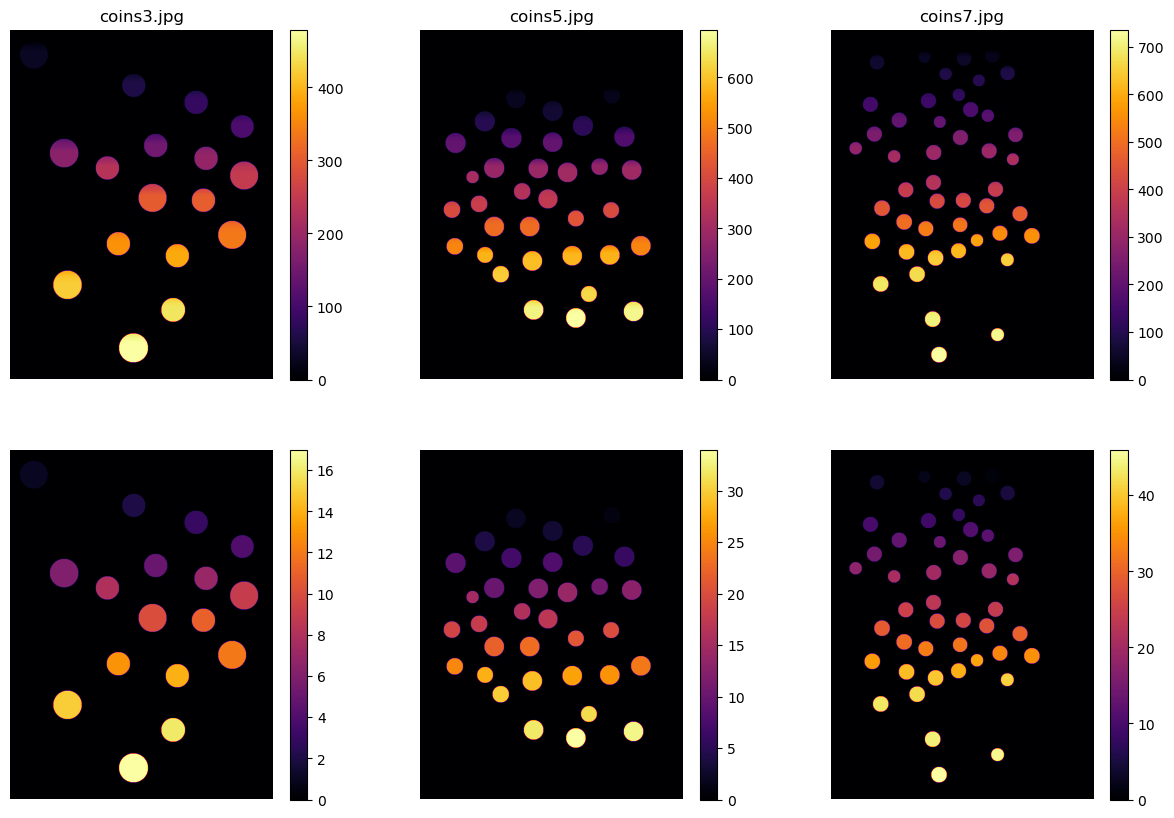

In [10]:
# Samo nad 3 slike vrsimo medjukorake
labeled3, equivalence_list3 =  label_mask(coin_mask3)
print(f'Image coins3.jpg over labeling')
labeled5, equivalence_list5 =  label_mask(coin_mask5)
print(f'Image coins5.jpg over labeling')
labeled7, equivalence_list7 =  label_mask(coin_mask7)
print(f'Image coins7.jpg over labeling')

bw_label3 = connect_equivalent_regions(labeled3, equivalence_list3)
print(f'Image coins3.jpg over connecting')
bw_label5 = connect_equivalent_regions(labeled5, equivalence_list5)
print(f'Image coins5.jpg over connecting')
bw_label7 = connect_equivalent_regions(labeled7, equivalence_list7)
print(f'Image coins7.jpg over connecting')

plt.figure(figsize=(15,10))
plt.subplot(231); cax1 = plt.imshow(labeled3, cmap='inferno'); plt.title('coins3.jpg'); plt.colorbar(cax1, orientation='vertical'); plt.axis('off');
plt.subplot(232); cax2 = plt.imshow(labeled5, cmap='inferno'); plt.title('coins5.jpg'); plt.colorbar(cax2, orientation='vertical'); plt.axis('off');
plt.subplot(233); cax3 = plt.imshow(labeled7, cmap='inferno'); plt.title('coins7.jpg'); plt.colorbar(cax3, orientation='vertical'); plt.axis('off');
plt.subplot(234); cax4 = plt.imshow(bw_label3, cmap='inferno'); plt.colorbar(cax4, orientation='vertical'); plt.axis('off'); 
plt.subplot(235); cax5 = plt.imshow(bw_label5, cmap='inferno'); plt.colorbar(cax5, orientation='vertical'); plt.axis('off');
plt.subplot(236); cax6 = plt.imshow(bw_label7, cmap='inferno'); plt.colorbar(cax6, orientation='vertical'); plt.axis('off');

In [11]:
# Nad ostalim slikama vrsimo celu funkciju

bw_label1 = bw_label(coin_mask1)
print(f'Image coins1.jpg over')
bw_label2 = bw_label(coin_mask2)
print(f'Image coins2.jpg over')
bw_label4 = bw_label(coin_mask4)
print(f'Image coins4.jpg over')
bw_label6 = bw_label(coin_mask6)
print(f'Image coins6.jpg over')
bw_label8 = bw_label(coin_mask8)
print(f'Image coins8.jpg over')
bw_label9 = bw_label(coin_mask9)
print(f'Image coins9.jpg over')

Image coins1.jpg over
Image coins2.jpg over
Image coins4.jpg over
Image coins6.jpg over
Image coins8.jpg over
Image coins9.jpg over


## 1.5. Poređenje broja pronađenih regiona

Kao što smo gore opisali, sada ćemo izdvojiti podatke iz tabele i spojiti ih sa brojem nađenih regiona (maksimum labelirane slike).

In [12]:
# Ekstraktovanje podataka iz pdf-a
def extract_text_from_pdf(pdf_path):
    '''
    Funkcija izdvaja tekst iz pdf-a
    
    Ulazi:
    - pdf_path (string): putanja do pdf-a sa tekstom
    
    Izlazi:
    - text (string): tekst koji se nalazio u pdf-u  
    '''
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(doc.page_count):
        page = doc[page_num]
        text += page.get_text()
    doc.close()
    return text

# Izdvajanje teksta iz pdf-a
pdf_text = extract_text_from_pdf('../sekvence/coins/coin class.pdf')
lines = pdf_text.split('\n')
lines = [line for line in lines if line.strip()]

# Kreiranje liste koja ce predstavljati podatke iz pdf-a
table_data = []
num_columns = 4

for i in range(0, len(lines), num_columns):
    row = lines[i:i + num_columns]
    table_data.append(row)

In [13]:
# Selektujemo naziv slike i broj regiona u slici
selected_data = [[row[0], row[3]] for row in table_data[1:]]

# Podatke prikazujemo kao pandas Dataframe
df = pd.DataFrame(selected_data, columns=["Slika", "Broj novcica u slici"])

# Broj detektovanih novcica
num_of_circles = [max(bw_label1.flatten()), max(bw_label2.flatten()), max(bw_label3.flatten()), max(bw_label4.flatten()), \
                  max(bw_label5.flatten()), max(bw_label6.flatten()), max(bw_label7.flatten()), max(bw_label8.flatten()), \
                  max(bw_label9.flatten())]
num_of_circles = [int(elem) for elem in num_of_circles]

# Dodajemo ovu kolonu u tabelu
df["Broj detektovanih novcica"] = num_of_circles

# Prikaz tabele
df

Slika Broj novcica u slici  Broj detektovanih novcica
0  coins1                   46                         46
1  coins2                   23                         23
2  coins3                   17                         17
3  coins4                   11                         11
4  coins5                   34                         34
5  coins6                   32                         32
6  coins7                   46                         46
7  coins8                   46                         46
8  coins9                   35                         35

**Komentar za rezultate**:

Detekcija regiona najviše zavisi od robusnosti funkcije coin_mask i brzine funkcije bw_label. Testirao sam razne ideje za detekciju novčića dok nisam uspeo nad ovim skupom slika da realizujem detekciju svih novčića. 

## 1.6. Klasifikacija

Poslednju funkciju ćemo realizovati u nekoliko koraka. Prvo ćemo prebrojati broj piksela u svakom novčiću, tj. **površinu novčića**. Nakon toga ćemo izvršiti **klasterizaciju** broja piksela u novčiću u dve klase. Ovo vršimo pomoću **KMean algoritma**, ugrađenom u biblioteci SkLearn. Ova funkcija će nam naći optimalan prag za poređenje površina piksela. Rezultate ovih međukoraka ćemo prikazati na 2 slike iz dataset-a. Odabrao sam slike coins3.jpg i coins5.jpg, zato što prikazuju slučajeve kada su klase bliže i dalje, a druga takođe ima jedan outlier koji je dosta manji od ostalih.

In [14]:
def get_circle_areas(bw_img):
    '''
    Nalazi povrsine novcica u broju piksela
    
    Ulazi:
    - bw_img (numpy.ndarray): Slika sa labeliranim nepreklapajućim elementima
    
    Izlazi:
    - areas (list): Lista broja piksela po regionu (novcicu)
    '''
    N, M = bw_img.shape
    areas = np.zeros(int(max(bw_img.flatten())))
    for i in range(N):
        for j in range(M):
            if bw_img[i][j]>0:
                areas[int(bw_img[i, j]-1)] +=1   
    return areas

In [15]:
def get_threshold(areas):
    '''
    Nalazi optimalan prag za poredjenje povrsina novcica
    
    Ulazi:
    - areas (list): Lista broja piksela po regionu (novcicu)
    
    Izlazi:
    - threshold_value (float): Optimalan prag za podelu klasa
    '''
    # Reshape areas_of_circles into a 2D array
    areas_2d = np.array(areas).reshape(-1, 1)

    # Use KMeans to cluster the data into two groups
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(areas_2d)

    # The threshold is the mean of the cluster centers
    threshold_value = np.mean(kmeans.cluster_centers_)
    return threshold_value

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there

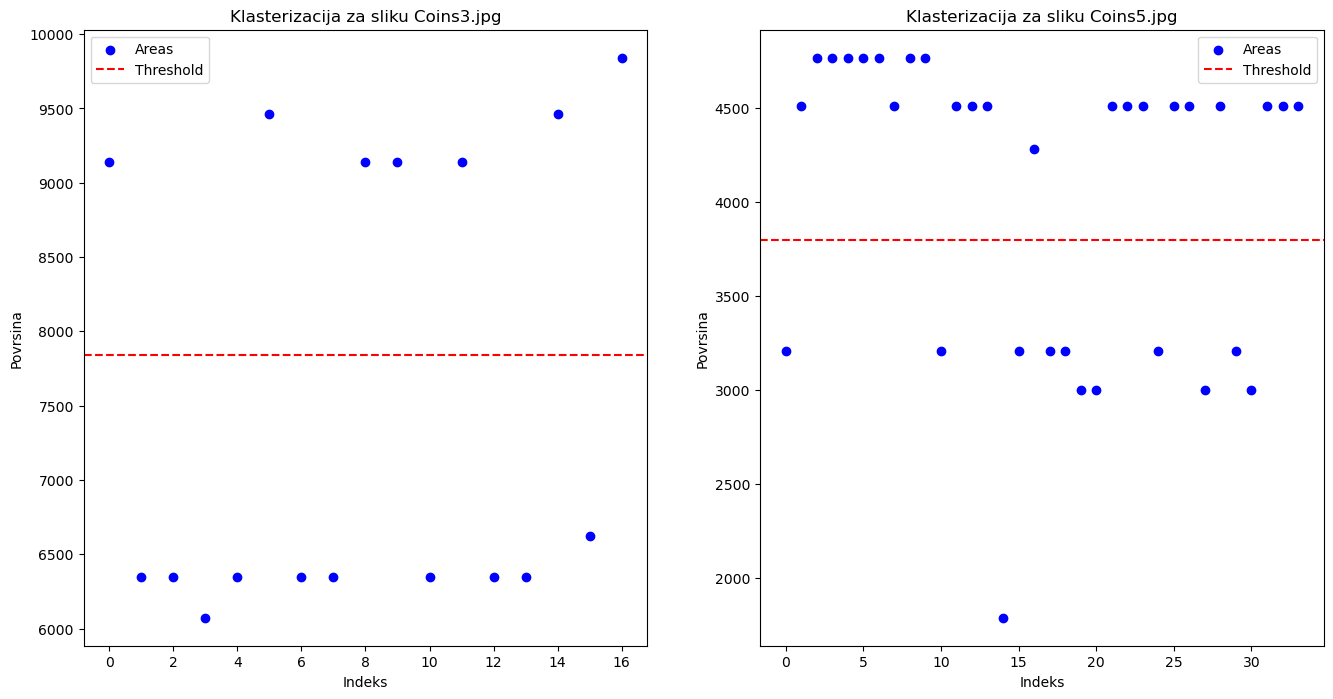

In [16]:
# Za slike 3 i 5 cemo prikazati kako radi klasterovanje
areas3 = get_circle_areas(bw_label3)
areas5 = get_circle_areas(bw_label5)

threshold_value3 = get_threshold(areas3)
threshold_value5 = get_threshold(areas5)

areas3_2d = np.array(areas3).reshape(-1, 1)
areas5_2d = np.array(areas5).reshape(-1, 1)

plt.figure(figsize=(16,8))
plt.subplot(121); plt.scatter(range(len(areas3_2d)), areas3_2d, marker='o', color='b', label='Areas');
plt.axhline(y=threshold_value3, color='r', linestyle='--', label='Threshold'); plt.title('Klasterizacija za sliku Coins3.jpg');
plt.xlabel('Indeks'); plt.ylabel('Povrsina'); plt.legend();
plt.subplot(122); plt.scatter(range(len(areas5_2d)), areas5_2d, marker='o', color='b', label='Areas');
plt.axhline(y=threshold_value5, color='r', linestyle='--', label='Threshold'); plt.title('Klasterizacija za sliku Coins5.jpg');
plt.xlabel('Indeks'); plt.ylabel('Povrsina'); plt.legend();

Ova dva međukoraka ćemo iskoristiti u konačnoj funkciji. Osim ova dva koraka, u funkciji ćemo realizovati i da se nad originalnom slikom **labeliraju novčići** da li su od 1 dinar ili 5 dinara i **da se oboje**. Nakon toga ćemo primeniti ovu funkciju nad svim 9 slika iz dataset-a. Sledi realizacija treće funkcije:

In [17]:
def coin_classification(img):
    '''
    Funkcija klasifikuje novcice u ulaznoj slici.
    
    Ulaz:
    - img (numpy.ndarray): Ulazna slika u boji
    
    Izlaz:
    - [number_of_1s, number_of_5s] (list): Broj novcica manje i vece povrsine na ulaznoj slici
    - colored_image (numpy.ndarray): Slika sa labeliranim novcicima
    '''
    # COIN_MASK
    coin_mask_temp = coin_mask(img)
    print(f'End of coin_mask')
    
    # BW_LABEL
    bw_img = bw_label(coin_mask_temp)
    print(f'End of bw_label')
    
    # Odredjivanje povrsina novcica
    areas = get_circle_areas(bw_img)
    N = size(areas)
    
    # Niz areas klasifikujemo 
    threshold_value = get_threshold(areas) 

    # U ovim promenljivama cuvamo broj novcica po klasama
    number_of_1s = 0
    number_of_5s = 0
    
    # Na ovoj slici labeliramo novcice
    colored_image = img.copy()

    # Prolazimo kroz svaki region
    for i in range(0, N):
        # Nasumicna boja
        color = np.random.rand(3)
        # Labela ovog novcica u maski bw_img
        region_label = i + 1
        # Vrednost koju ispisujemo na novcicu
        digit = '' 
        
        # Maska za samo jedan novcic
        region_mask = (bw_img == region_label)
        
        # Bojimo novcic u nasumicnu boju
        colored_image[region_mask] = img[region_mask] * 0.2 + color * 0.8
        
        # Klasifikujemo novcic po povrsini
        if areas[i] > threshold_value:
            number_of_5s +=1
            digit = '5'
        else:
            number_of_1s +=1
            digit = '1'
        
        # Nalazenje centra novcica
        ys, xs = np.where(region_mask)
        centroid = (int(np.mean(xs)), int(np.mean(ys)))
        
        # Ispisivanje '1' ili '5' na novcic
        cv2.putText(colored_image, digit, (centroid[0], centroid[1]), cv2.FONT_HERSHEY_DUPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)
            
    return [number_of_1s, number_of_5s], colored_image

## 1.7. Vrsenje fje nad svim slikama

Učitaćemo svih 9 slika iz dataset-a. Nad njima ćemo izvršiti prethodnu funkciju, a rezultate čuvamo u 3 niza. Nakon izvršavanja ovog dela, čuvamo slike sa obeleženim površinama i klasama novčića. Onda koristimo podatke da kreiramo traženu tabelu.

In [18]:
# Ucitavanje slika iz baze
images = []
for i in range(0,9):
    images.append(skimage.img_as_float(imread('../sekvence/coins/coins'+str(i+1)+'.jpg')))
print(f'Zavrseno ucitavanje slika')

arr_1s = []
arr_5s = []
colored_images = []

for i in range(0,9):
    print(f'Zapoceta klasifikacija slike Coins{i+1}.jpg')
    [number_of_1s, number_of_5s], colored_image = coin_classification(images[i])
    arr_1s.append(number_of_1s)
    arr_5s.append(number_of_5s)
    colored_images.append(colored_image)
    print(f'Gotova klasifikacija slike Coins{i+1}.jpg')

Zavrseno ucitavanje slika
Zapoceta klasifikacija slike Coins1.jpg
End of coin_mask
End of bw_label


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Gotova klasifikacija slike Coins1.jpg
Zapoceta klasifikacija slike Coins2.jpg
End of coin_mask
End of bw_label


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Gotova klasifikacija slike Coins2.jpg
Zapoceta klasifikacija slike Coins3.jpg
End of coin_mask
End of bw_label


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Gotova klasifikacija slike Coins3.jpg
Zapoceta klasifikacija slike Coins4.jpg
End of coin_mask
End of bw_label


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Gotova klasifikacija slike Coins4.jpg
Zapoceta klasifikacija slike Coins5.jpg
End of coin_mask
End of bw_label


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Gotova klasifikacija slike Coins5.jpg
Zapoceta klasifikacija slike Coins6.jpg
End of coin_mask
End of bw_label


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Gotova klasifikacija slike Coins6.jpg
Zapoceta klasifikacija slike Coins7.jpg
End of coin_mask
End of bw_label


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Gotova klasifikacija slike Coins7.jpg
Zapoceta klasifikacija slike Coins8.jpg
End of coin_mask
End of bw_label


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Gotova klasifikacija slike Coins8.jpg
Zapoceta klasifikacija slike Coins9.jpg
End of coin_mask
End of bw_label


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Gotova klasifikacija slike Coins9.jpg


In [19]:
# Direktorijum u kom cuvamo slike
output_directory = 'coins_labeled'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Cuvamo slike iz niza colored_images
for i in range(0, len(colored_images)):
    image_filename = f'coins{i + 1}_labeled.jpg' 
    output_path = os.path.join(output_directory, image_filename)
    io.imsave(output_path, colored_images[i])

print(f"Images saved to {output_directory}")

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Images saved to coins_labeled


In [20]:
df = pd.DataFrame(table_data[1:], columns=[x.capitalize() for x in table_data[0]])
df["1din"] = arr_1s
df["5din"] = arr_5s
error_1s = []
error_5s = []
for i in range(1,10):
    error_1s.append(np.abs(int(table_data[i][1]) - arr_1s[i - 1]))
    error_5s.append(np.abs(int(table_data[i][2]) - arr_5s[i - 1]))
df["Greska 1. klase"] = error_1s
df["Greska 2. klase"] = error_5s
print(f'Prikaz tabele sa informacijama o klasifikaciji novcica:')
df

Prikaz tabele sa informacijama o klasifikaciji novcica:


Şlika Klasa 1 Klasa 2 Ukupno  1din  5din  Greska 1. klase  Greska 2. klase
0  coins1      12      34     46    12    34                0                0
1  coins2       4      19     23     4    19                0                0
2  coins3      10       7     17    10     7                0                0
3  coins4       7       4     11     7     4                0                0
4  coins5      12      22     34    12    22                0                0
5  coins6      11      21     32    11    21                0                0
6  coins7      12      34     46    12    34                0                0
7  coins8      12      34     46    12    34                0                0
8  coins9      12      23     35    12    23                0                0

**Komentar:**

Kao što vidimo, moje funkcije detektuju sve novčiće iz dataset-a. Da bismo ove funkcije prilagodili drugim dataset-ovima, pre svega bismo morali da promenimo prvu funkciju. O ovome sam gore pričao, ali morali bismo drugačije da odaberemo poluprečnike novčića i pragove da bi se sve detektovalo. Druga i Treća funkcija ne zahtevaju neku promenu ako bismo promenili dataset.

# Zadatak 2 (Kanijev algoritam)

Algoritam se sastoji iz nekoliko koraka. U ovom notebook-u ćemo pokazati korake za realizaciju Kanijevog algoritma. Uz svaki korak ćemo pokazati međurezultate na datim slikama iz odgovarajuće baze ( *../sekvence/* ). Nakon realizacije svih međukoraka, spojićemo ih u jednu funkciju *canny_edge_detection*. Na raspolaganju su nam 3 slike: lenna, camerman i van. Posle realizacije funkcije ćemo pokazati uticaj odabira parametara na izlaz funkcije, a zatim ćemo podesiti parametre za slike koje imamo u bazi i nad njima detektovati adekvatno ivice. 

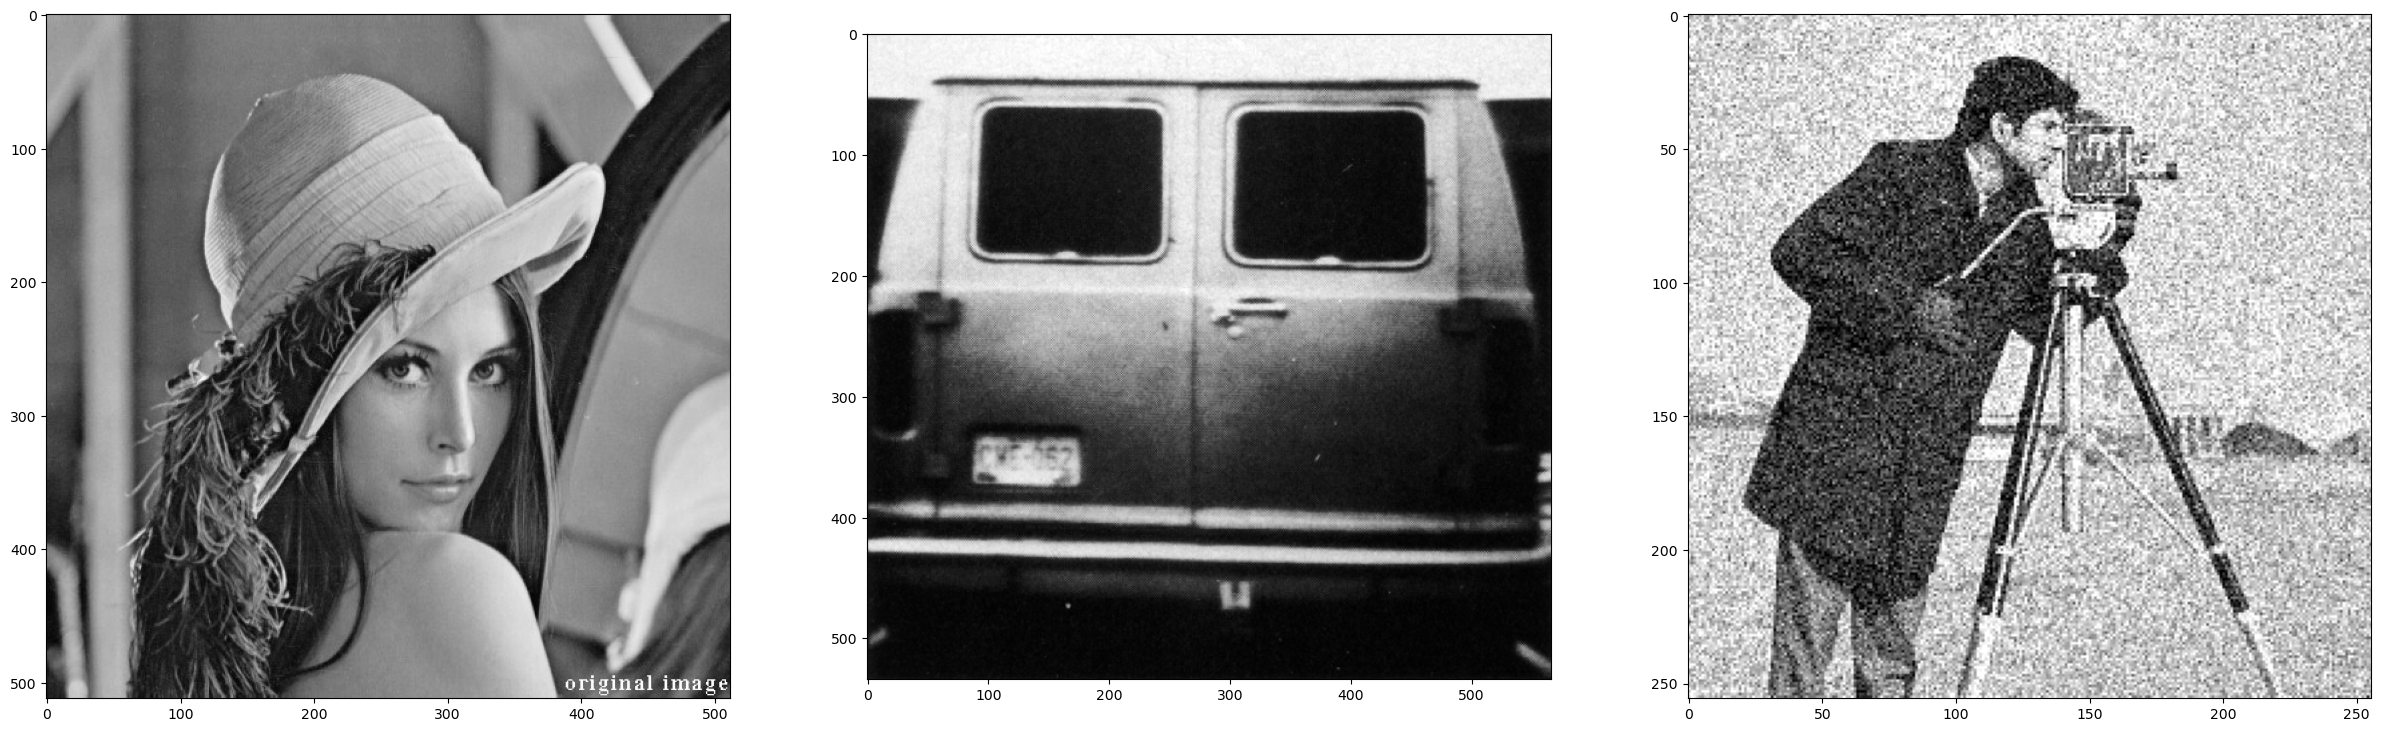

In [21]:
# Importovanje potrebnih biblioteka
import numpy as np
from __future__ import print_function
%matplotlib inline
import scipy
from scipy import ndimage
from scipy import *
from pylab import *

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import skimage
from skimage import *
from skimage import color
from skimage import exposure
from skimage import filters
from skimage import feature
from skimage import io
import math

# Ucitavanje slika iz baze
img1 = skimage.img_as_float(imread('../sekvence/lena.tif'));
img2 = skimage.img_as_float(imread('../sekvence/van.tif'));
img3 = skimage.img_as_float(imread('../sekvence/camerman.tif'));

# Prikaz originalnih slika iz baze
plt.figure(figsize=(30,10))
plt.subplot(131); plt.imshow(img1, cmap='gray'); #plt.axis('off');
plt.subplot(132); plt.imshow(img2, cmap='gray'); #plt.axis('off');
plt.subplot(133); plt.imshow(img3, cmap='gray'); #plt.axis('off');

**Napomena**: 

Ostavio sam ose na slikama da bismo uočili da su prve dve slike večih dimenzija od treće. Ovo će uticati na vreme izvršavanja. Konkretno, svi međukoraci su složenosti $o(n^2)$, sa izuzetkom poslednjeg koraka koji je složenosti između  $o(n^2)$ i $o(n^3)$.

Osim toga, primetimo da je druga slika mutnija, dok je treća slika zašumljena. Ovo će uticati na rezultat detekcije ivica, ali i na odabir parametara na kraju, kada budemo podešavali parametre za svaku sliku.

## 2.1 Filtriranje Gausovim filtrom

Naše ulazne slike mogu imati neki **nivo šuma** u sebi. Kao što smo videli, naša treća slika u bazi ima znatno jači šum. Ovo utiče na gradijente slike. Da bismo umanjili efekat šuma na gradijent (koji nam je potreban za dalju detekciju), moramo da ga potisnemo, tj. filtriramo sliku lowpass filtrom. Šum možemo da modeliramo kao **gausov**, a ovo modelovanje je opravdano zbog centralne granične teoreme. Za potrebe filtriranja ćemo koristiti gausov filtar, zadate standardne devijacije $\sigma$, a za poluprečnik filtra ćemo koristiti $6\cdot\sigma$ (prvi neparan ceo broj veći od ovoga).

In [22]:
def filter_gaussian(img, sigma):
    '''
    Filtrira ulaznu sliku gausovim filtrom. Za radius filtra uzima 6*sigma
    
    Ulazi:
    - img (numpy.ndarray): ulazna siva slika
    - sigma (float): st. devijacija gausovog filtra
    
    Izlazi: 
    - img_filt (numpy.ndarray): izlazna filtrirana slika
    
    '''
    # Odredjivanje radiusa
    radius = math.ceil(6*sigma)
    if radius % 2 == 0:
        radius = radius + 1

    # truncate*sigma=radius
    truncate = radius/sigma # Parametar potreban za filtar

    # Filtriranje
    img_filt = skimage.filters.gaussian(img, sigma, mode='mirror', truncate = truncate)
    
    return img_filt

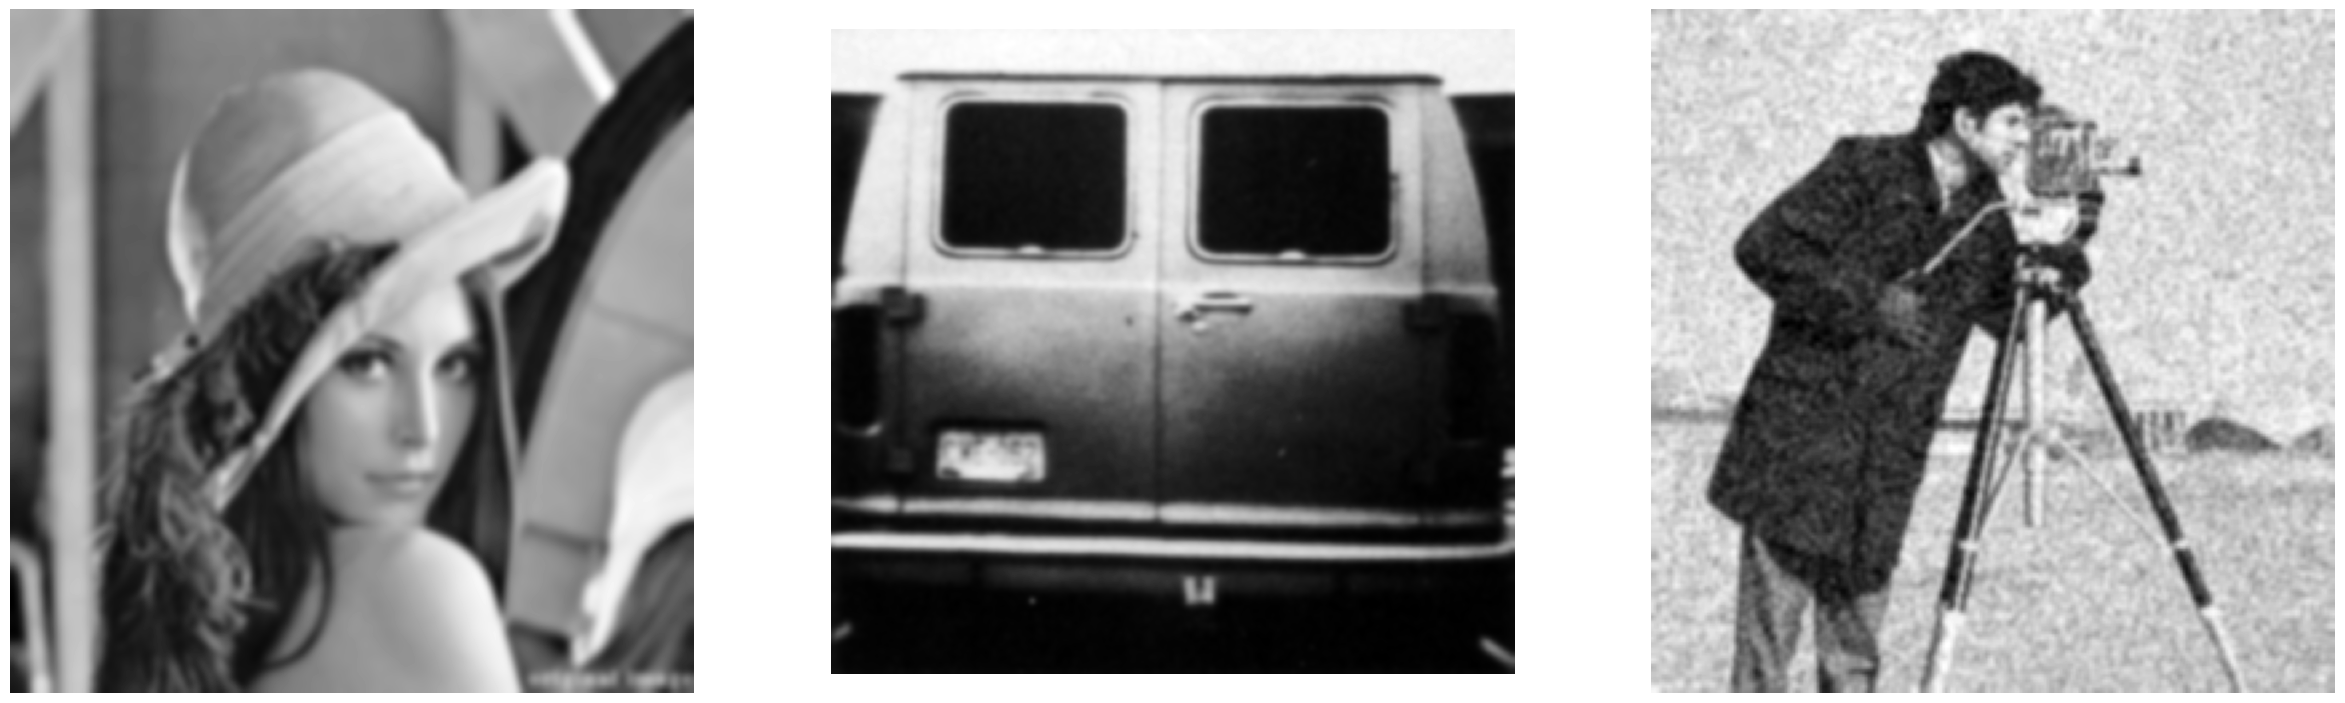

In [23]:
# Filtriranje slika iz baze
img_filt1 = filter_gaussian(img1, 3)
img_filt2 = filter_gaussian(img2, 2)
img_filt3 = filter_gaussian(img3, 1)

# Prikaz medjurezultata
plt.figure(figsize=(30,10))
plt.subplot(131); plt.imshow(img_filt1, cmap='gray'); plt.axis('off');
plt.subplot(132); plt.imshow(img_filt2, cmap='gray'); plt.axis('off');
plt.subplot(133); plt.imshow(img_filt3, cmap='gray'); plt.axis('off');

## 2.2. Odredjivanje horizontalnih i vertikalnih gradijenata

Nakon što smo potisnuli šum, sada možemo da odredimo gradijente slike po pravcima. Za potrebe nalaženja gradijenata, koristimo **Sobelov operator**.

In [24]:
def image_gradients(img_filt):
    '''
    Nalazenje gradijenata ulazne slike po pravcima
    
    Ulazi:
    - img_filt (numpy.ndarray): ulazna siva (vec filtrirana) slika
    
    Izlazi:
    -Gx (numpy.ndarray): Gradijent ulazne slike po pravcu x ose
    -Gy (numpy.ndarray): Gradijent ulazne slike po pravcu y ose
    '''
    # Sobelov operator
    Hx = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])
    Hy = np.transpose(Hx) # transponovanje matrice
    
    # izracunavanje vertikalnog i horizontalnog gradijenta slike
    Gx = scipy.ndimage.convolve(img_filt, Hx, mode='nearest')
    Gy = scipy.ndimage.convolve(img_filt, Hy, mode='nearest')
    
    return Gx, Gy

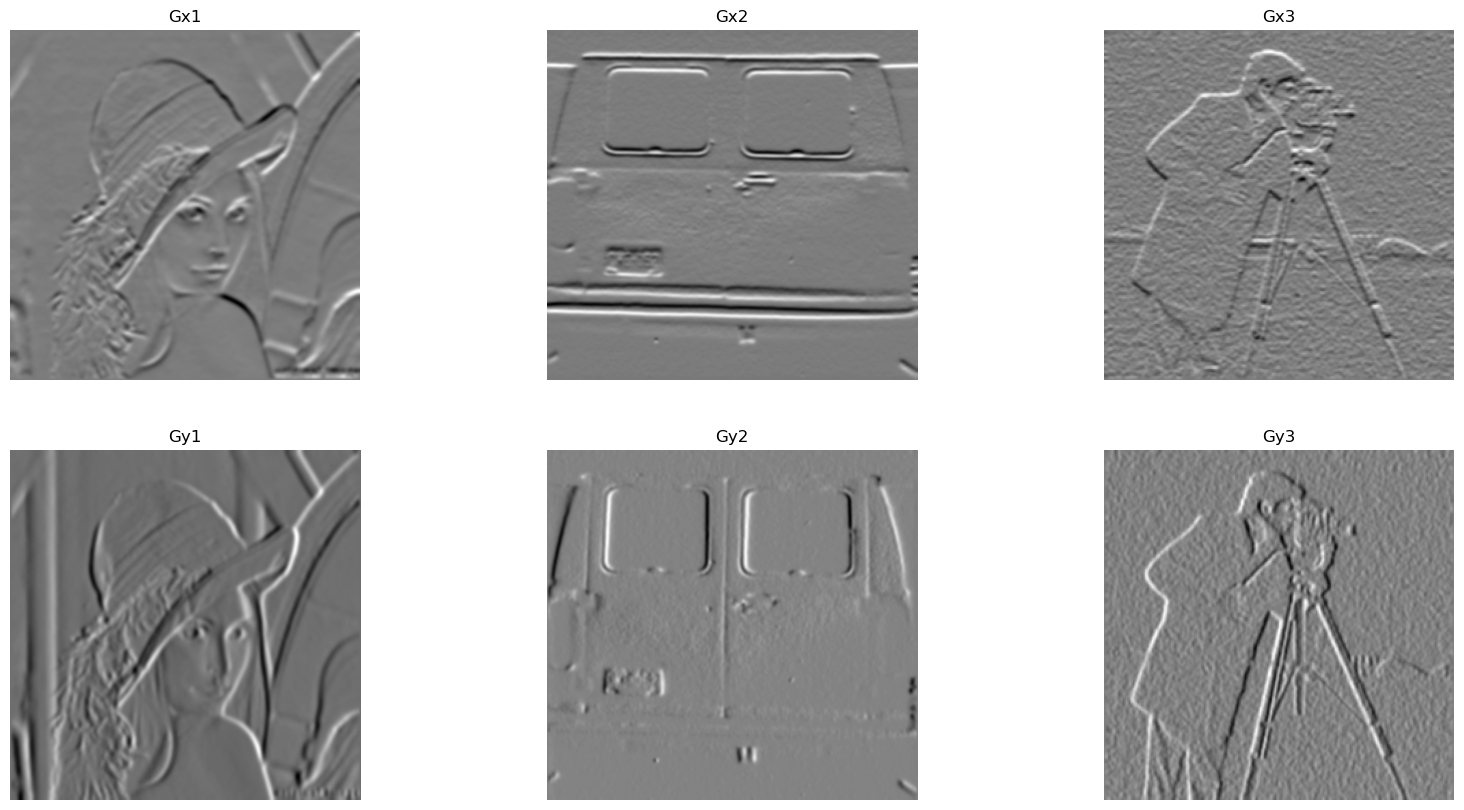

In [25]:
# Gradijenti filtriranih slika
Gx1, Gy1 = image_gradients(img_filt1)
Gx2, Gy2 = image_gradients(img_filt2)
Gx3, Gy3 = image_gradients(img_filt3)

# Prikaz medjurezultata
plt.figure(figsize=(20,10));
plt.subplot(231); plt.imshow(Gx1, cmap='gray'); plt.axis('off'); plt.title('Gx1');
plt.subplot(232); plt.imshow(Gx2, cmap='gray'); plt.axis('off'); plt.title('Gx2');
plt.subplot(233); plt.imshow(Gx3, cmap='gray'); plt.axis('off'); plt.title('Gx3');
plt.subplot(234); plt.imshow(Gy1, cmap='gray'); plt.axis('off'); plt.title('Gy1');
plt.subplot(235); plt.imshow(Gy2, cmap='gray'); plt.axis('off'); plt.title('Gy2');
plt.subplot(236); plt.imshow(Gy3, cmap='gray'); plt.axis('off'); plt.title('Gy3');

## 2.3. Magnituda i ugao gradijenta

Gradijente određene u prethodnom koraku sada koristimo za nalaženje magnitude i ugla ivice. Koristimo sledeće izraze:

$mag(x,y) = \sqrt{G_x(x,y)^2+G_y(x,y)^2}$

$angle(x,y) = arctan\frac{Gy(x,y)}{Gx(x,y)}$ 

In [26]:
def magnitude_and_angle(Gx, Gy):
    '''
    Nalazi magnitudu i ugao gradijenta
    
    Ulazi:
    -Gx (numpy.ndarray): Gradijent ulazne slike po pravcu x ose
    -Gy (numpy.ndarray): Gradijent ulazne slike po pravcu y ose
    
    Izlazi:
    - mag (numpy.ndarray): Magnituda gradijenta
    - angle (numpy.ndarray): Ugao gradijenta (u stepenima)
    '''
    # magnituda gradijenta
    mag = np.sqrt(np.square(Gx) + np.square(Gy))
    
    # Ugao gradijenta
    angle = np.rad2deg(np.arctan2(Gy, Gx))
    
    return mag, angle

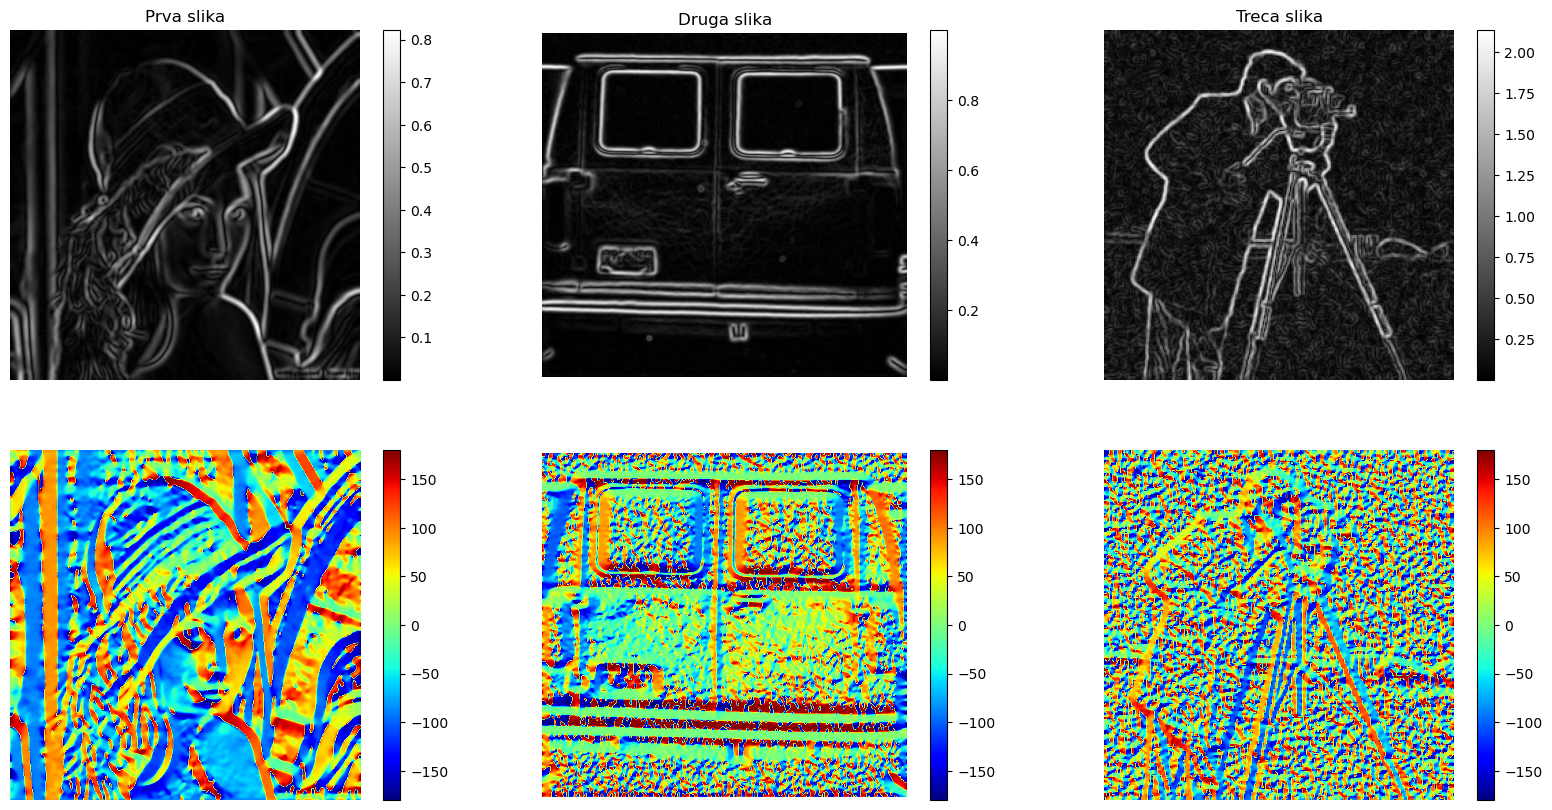

In [27]:
# Odredjivanje mag i angle za ulazne slike
mag1, angle1 = magnitude_and_angle(Gx1, Gy1)
mag2, angle2 = magnitude_and_angle(Gx2, Gy2)
mag3, angle3 = magnitude_and_angle(Gx3, Gy3)

# Prikaz medjurezultata
plt.figure(figsize=(20,10));
plt.subplot(231); plt.imshow(mag1, cmap='gray'); plt.axis('off'); plt.colorbar(); plt.title('Prva slika');
plt.subplot(232); plt.imshow(mag2, cmap='gray'); plt.axis('off'); plt.colorbar(); plt.title('Druga slika');
plt.subplot(233); plt.imshow(mag3, cmap='gray'); plt.axis('off'); plt.colorbar(); plt.title('Treca slika');
plt.subplot(234); plt.imshow(angle1, cmap='jet'); plt.colorbar(); plt.axis('off');
plt.subplot(235); plt.imshow(angle2, cmap='jet'); plt.axis('off'); plt.colorbar();
plt.subplot(236); plt.imshow(angle3, cmap='jet'); plt.axis('off'); plt.colorbar();

## 2.4. Kvantizacija pravca gradijenta

Moramo da obezbedimo da širine ivica budu jedan piksel. Da bismo ovo realizovali, potrebno je nekoliko međukoraka:
- **kvantizacija pravca**: Određujemo u kom od 4 pravaca je ivica na osnovu ugla
- **potiskivanje lokalnih neminimuma**: Na osnovu pravca ivice, posmatramo susedne piksele. Ako je trenutni piksel veći od susednih, samo on je ivični

In [28]:
def quantise_angles(angle):
    '''
    Kvantizacija pravca ivica na osnovu ugla
    
    Ulazi:
    - angle (numpy.ndarray): Ugao gradijenta (u stepenima)
    
    Izlazi:
    - edge_quantised_angles (numpy.ndarray): Istih dimenzija kao ulaz. Svaki piksel uzima jednu od 4 vrednosti: -45, 0, 45, 90
    '''
    edge_quantised_angles = np.zeros(angle.shape)
    N, M = angle.shape
    for i in range(0, N):
        for j in range(0, M):
            curr = angle[i, j]
            # Proveravamo vrednost ugla u stepenima
            if (curr<=22.5 and curr>-22.5) or (curr>157.5) or (curr<=-157.5):
                edge_quantised_angles[i, j] = 0
            elif (curr<=67.5 and curr>22.5) or (curr>-157.5 and curr<=-112.5):
                edge_quantised_angles[i, j] = 45
            elif (curr<=112.5 and curr>67.5) or (curr>-112.5 and curr<=-67.5):
                edge_quantised_angles[i, j] = 90
            elif (curr<=157.5 and curr>112.5) or (curr>-67.5 and curr<=-22.5):
                edge_quantised_angles[i, j] = -45
    return edge_quantised_angles

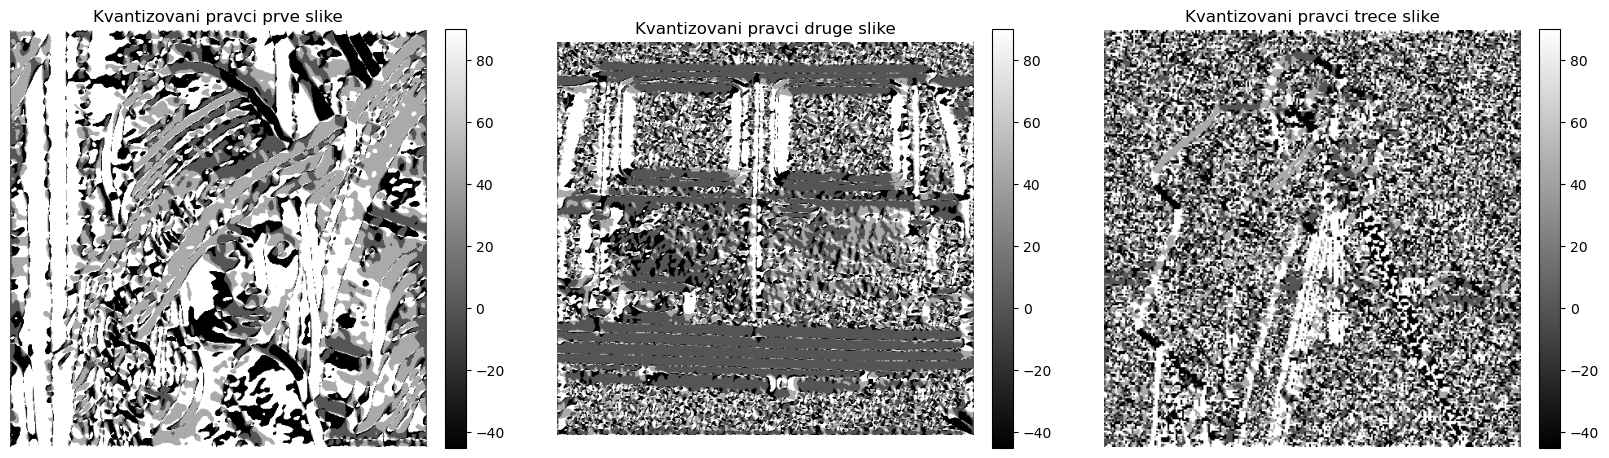

In [29]:
# Kvantizacija pravca gradijenata ulaznih slika
edge_quantised_angles1 = quantise_angles(angle1)
edge_quantised_angles2 = quantise_angles(angle2)
edge_quantised_angles3 = quantise_angles(angle3)

# Prikaz medjukoraka
plt.figure(figsize=(20,10));
plt.subplot(131); plt.imshow(edge_quantised_angles1, cmap='gray'); plt.axis('off'); plt.colorbar(fraction=0.046, pad=0.04); plt.title('Kvantizovani pravci prve slike');
plt.subplot(132); plt.imshow(edge_quantised_angles2, cmap='gray'); plt.axis('off'); plt.colorbar(fraction=0.046, pad=0.04); plt.title('Kvantizovani pravci druge slike');
plt.subplot(133); plt.imshow(edge_quantised_angles3, cmap='gray'); plt.axis('off'); plt.colorbar(fraction=0.046, pad=0.04); plt.title('Kvantizovani pravci trece slike');

## 2.5. Potiskivanje lokalnih nemaksimuma

U prethodnom segmentu smo objasnili zašto nam je ovaj korak potreban.

Moja funkcija radi na sledeći način:
- Prolazimo kroz svaki piksel
- Za trenutni piksel uzimamo vrednost magnitude, *mag*$[i, j]$
- Proveravamo pravac ivice trenutnog piksela, *edge_quantised_angles*$[i, j]$
- Vršimo zaštitnu proveru za indekse slike (edge-case-ovi)
- Proveramo da li je magnituda levog piksela veća od trenutnog, $left >= curr$. Ako jeste, trenutni piksel je lokalni nemaksimum. Postavljamo mu magnitudu 0
- Proveramo da li je magnituda desnog piksela veća od trenutnog, $right >= curr$. Ako jeste, trenutni piksel je lokalni nemaksimum. Postavljamo mu magnitudu 0

In [30]:
def local_maximums(mag, edge_quantised_angles):
    '''
    Potiskuje lokalne nemaksimume.
    
    Ulazi:
    - mag (numpy.ndarray): Magnituda gradijenta
    - edge_quantised_angles (numpy.ndarray): Svaki piksel uzima jednu od 4 vrednosti: -45, 0, 45, 90
    
    Izlazi:
    - mag_local_maximums (numpy.ndarray): Istih dimenzija kao ulazi. Magnitude ivica svedene na širinu od jedan piksel. 
    '''
    
    mag_local_maximums = mag.copy()
    N, M = mag.shape

    for i in range(0, N):
        for j in range(0, M):
            curr = mag[i, j]
            if edge_quantised_angles[i, j]==-45: 
                if j>0 and i<N-1:
                    left = mag[i+1, j-1]
                    if left>=curr:
                        mag_local_maximums[i, j] = 0
                        continue
                if i>0 and j<M-1:
                    right = mag[i-1, j+1]
                    if right>=curr:
                        mag_local_maximums[i, j] = 0
                        continue

            if edge_quantised_angles[i, j]==0:
                if i<N-1:
                    left = mag[i+1, j]
                    if left>=curr:
                        mag_local_maximums[i, j] = 0
                        continue
                if i>0:
                    right = mag[i-1, j]
                    if right>=curr:
                        mag_local_maximums[i, j] = 0
                        continue

            if edge_quantised_angles[i, j]==45:
                if i<N-1 and j<M-1:
                    left = mag[i+1, j+1]
                    if left>=curr:
                        mag_local_maximums[i, j] = 0
                        continue
                if i>0 and j>0:
                    right = mag[i-1, j-1]
                    if right>=curr:
                        mag_local_maximums[i, j] = 0
                        continue

            if edge_quantised_angles[i, j]==90:
                if j<M-1:
                    left = mag[i, j+1]
                    if left>=curr:
                        mag_local_maximums[i, j] = 0
                        continue
                if j>0:
                    right = mag[i, j-1]
                    if right>=curr:
                        mag_local_maximums[i, j] = 0
                        continue    
    return mag_local_maximums

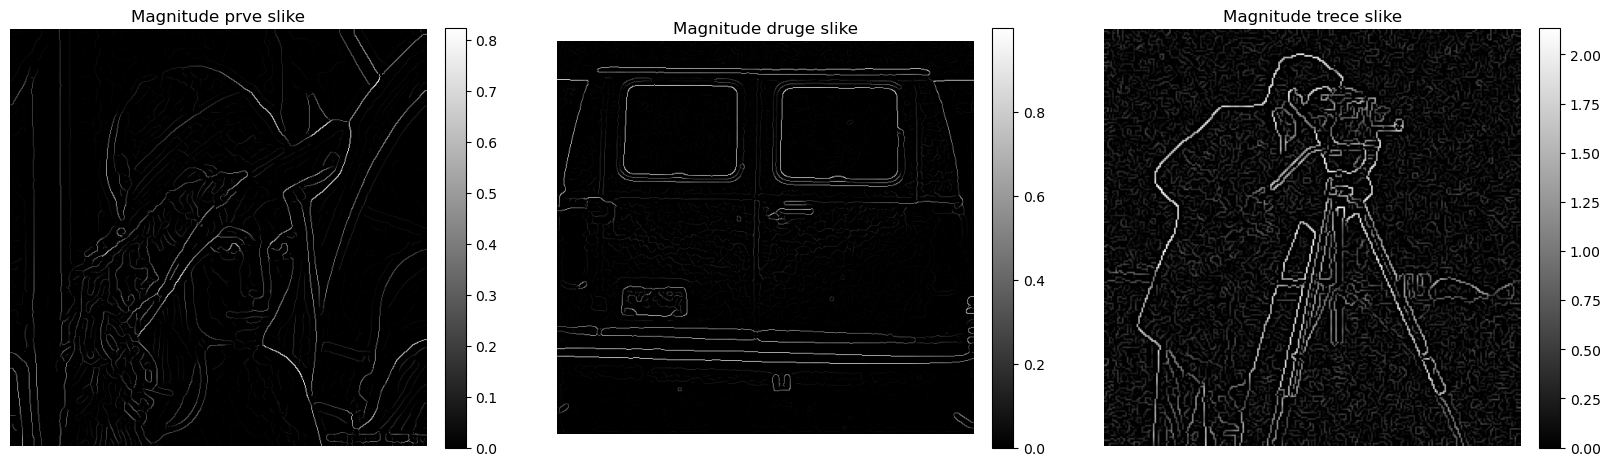

In [31]:
# Potiskivanje lokalnih nemaksimuma nad ulaznim slikama
mag_local_maximums1 = local_maximums(mag1, edge_quantised_angles1)
mag_local_maximums2 = local_maximums(mag2, edge_quantised_angles2)
mag_local_maximums3 = local_maximums(mag3, edge_quantised_angles3)

# Prikazivanje medjurezultata
plt.figure(figsize=(20,10));
plt.subplot(131); plt.imshow(mag_local_maximums1, cmap='gray'); plt.axis('off'); plt.colorbar(fraction=0.046, pad=0.04); plt.title('Magnitude prve slike');
plt.subplot(132); plt.imshow(mag_local_maximums2, cmap='gray'); plt.axis('off'); plt.colorbar(fraction=0.046, pad=0.04); plt.title('Magnitude druge slike');
plt.subplot(133); plt.imshow(mag_local_maximums3, cmap='gray'); plt.axis('off'); plt.colorbar(fraction=0.046, pad=0.04); plt.title('Magnitude trece slike');

## 2.6. Odredjivanje jakih i slabih ivica

Nakon što smo sveli ivice na širinu od jednog piksela, želimo da podelimo ivične piksele na jake i slabe. 

Ivični piksel je **jak** ako mu je magnituda veća od praga $T_h$.

Ivični piksel je **slab** ako mu je magnituda veća od praga $T_l$, a manja od praga $T_h$.

In [32]:
def strong_and_weak_edges(mag_local_maximums, Th, Tl):
    '''
    Na osnovu magnitude ivica odredjuje mape jakih i slabih ivica.
    
    Ulazi:
    - mag_local_maximums (numpy.ndarray): Magnitude ivica svedene na širinu od jedan piksel. 
    - Th (float): Gornji prag detekcije
    - Tl (float): Donji prag detekcije
    
    Izlazi:
    - strong_edges (numpy.ndarray): Istih dimenzija kao slika. Mapa jakih ivica
    - weak_edges (numpy.ndarray): Istih dimenzija kao slika. Mapa slabih ivica
    '''
    # Jake ivice
    strong_edges = np.zeros(mag_local_maximums.shape)
    strong_edges[mag_local_maximums>=Th] = 1
    # Slabe ivice
    weak_edges = np.zeros(mag_local_maximums.shape)
    weak_edges[mag_local_maximums>=Tl] = 1
    weak_edges[mag_local_maximums>=Th] = 0

    return strong_edges, weak_edges

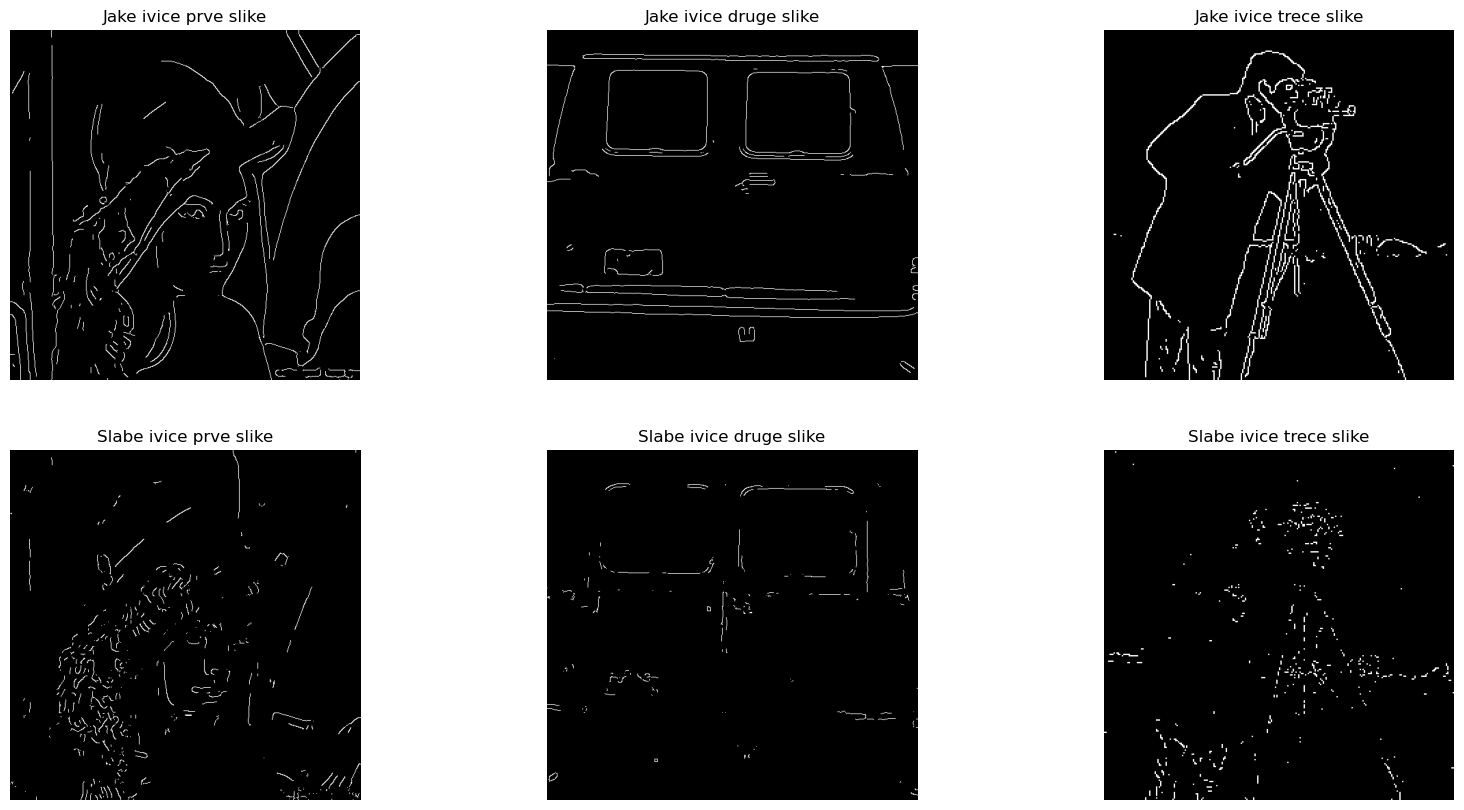

In [33]:
# Nalazenje jakih i slabih ivica ulaznih slika
strong_edges1, weak_edges1 = strong_and_weak_edges(mag_local_maximums1, 0.2, 0.1)
strong_edges2, weak_edges2 = strong_and_weak_edges(mag_local_maximums2, 0.4, 0.2)
strong_edges3, weak_edges3 = strong_and_weak_edges(mag_local_maximums3, 0.8, 0.6)

# Prikaz medjurezultata
plt.figure(figsize=(20,10));
plt.subplot(231); plt.imshow(strong_edges1, cmap='gray'); plt.axis('off'); plt.title('Jake ivice prve slike');
plt.subplot(232); plt.imshow(strong_edges2, cmap='gray'); plt.axis('off'); plt.title('Jake ivice druge slike');
plt.subplot(233); plt.imshow(strong_edges3, cmap='gray'); plt.axis('off'); plt.title('Jake ivice trece slike');
plt.subplot(234); plt.imshow(weak_edges1, cmap='gray'); plt.axis('off'); plt.title('Slabe ivice prve slike');
plt.subplot(235); plt.imshow(weak_edges2, cmap='gray'); plt.axis('off'); plt.title('Slabe ivice druge slike');
plt.subplot(236); plt.imshow(weak_edges3, cmap='gray'); plt.axis('off'); plt.title('Slabe ivice trece slike');

## 2.7. Ukljucivanje slabih ivica povezanih sa jakim

Poslednji korak je da dodamo u masku one slabe ivične piksele koji su povezani sa jakim.

Funkciju realizujemo na sledeći način:
- Vršimo iteracije nad maskom slabih ivica dok god se neki pikseli dodavaju
- Ukoliko se u prethodnoj iteraciji nije dodao nijedan piksel, stajemo sa iteracijama
- **Jedna iteracija** podrazumeva sledeće:
    - Za svaki piksel u maski slabih ivičnih piksela proveravamo da li joj se u 8-susedstvu ima bar jedan jak ivični piksel
    - Ukoliko ima, ovaj piksel prebacujemo iz slabih u jake
    - 8-susedstvo sa jakim pikselom proveravamo sumiranjem susednih piksela i onda proverom $sum>0$

In [34]:
def connect_edges(weak_edges, strong_edges):
    N, M = weak_edges.shape
    flag = True
    while(flag):
        flag = False
        for i in range(0, N):
            for j in range(0, M):
                if weak_edges[i, j]==1:
                    # Provera da li u susedstvu ima jaku ivicu
                    sum = 0
                    if i>0:
                        sum = sum + strong_edges[i-1, j]
                        if j>0:
                            sum = sum + strong_edges[i-1, j-1]
                        if j<M-1:
                            sum = sum + strong_edges[i-1,j+1]
                    if i<N-1:
                        sum = sum + strong_edges[i+1, j]
                        if j>0:
                            sum = sum + strong_edges[i+1, j-1]
                        if j<M-1:
                            sum = sum + strong_edges[i+1,j+1]
                    if j>0:
                        sum = sum + strong_edges[i, j-1]
                    if j<M-1:
                        sum = sum + strong_edges[i, j+1]
                    if sum>0:
                        # Postoji jaki ivicni piksel u okolini
                        # Ovaj piksel prebacujemo u jake
                        strong_edges[i, j]=1
                        weak_edges[i, j]=0
                        flag = True
    return strong_edges

Zavrseno povezivanje za prvu sliku
Zavrseno povezivanje za drugu sliku
Zavrseno povezivanje za trecu sliku


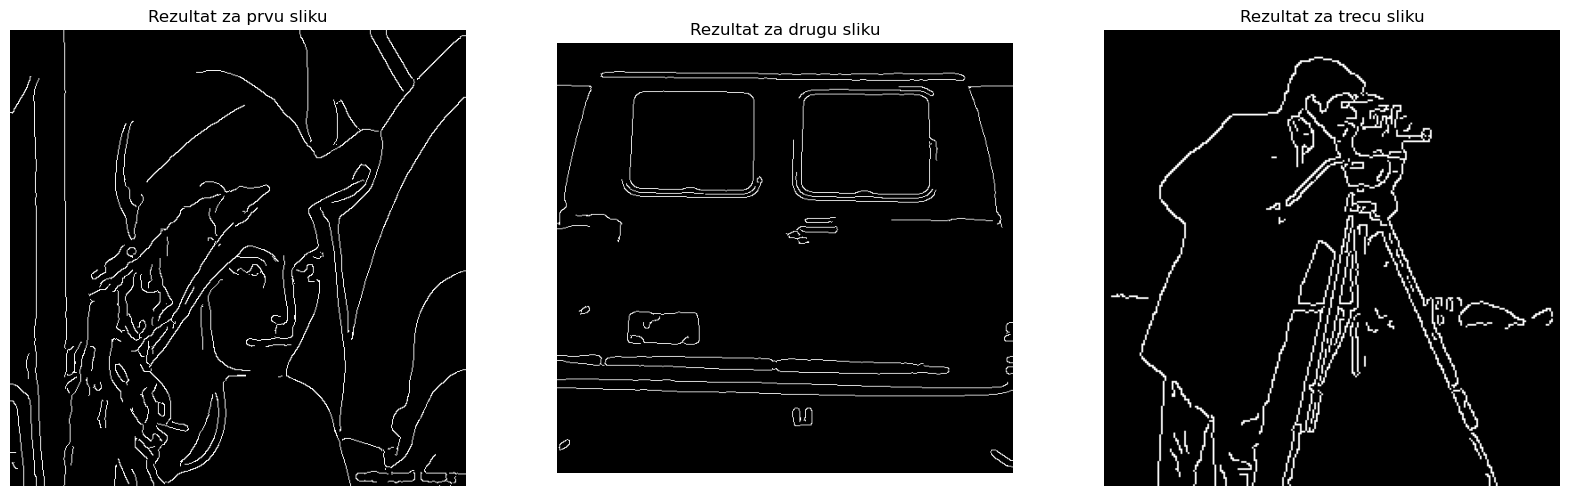

In [35]:
# Povezivanje za ulazne slike
strong_edges1 = connect_edges(weak_edges1, strong_edges1)
print(f'Zavrseno povezivanje za prvu sliku')
strong_edges2 = connect_edges(weak_edges2, strong_edges2)
print(f'Zavrseno povezivanje za drugu sliku')
strong_edges3 = connect_edges(weak_edges3, strong_edges3)
print(f'Zavrseno povezivanje za trecu sliku')

# Prikaz medjukoraka
plt.figure(figsize=(20,10));
plt.subplot(131); plt.imshow(strong_edges1, cmap='gray'); plt.axis('off'); plt.title('Rezultat za prvu sliku');
plt.subplot(132); plt.imshow(strong_edges2, cmap='gray'); plt.axis('off'); plt.title('Rezultat za drugu sliku');
plt.subplot(133); plt.imshow(strong_edges3, cmap='gray'); plt.axis('off'); plt.title('Rezultat za trecu sliku');

## 2.8. Realizacija funkcije

Sve prethodne međukorake ćemo spojiti u jednu funkciju. Tek u ovoj funkciji vršimo **proveru ulaznih parametara**.

In [36]:
def canny_edge_detection(img, sigma = 1, Th = 0.5, Tl = 0.1):
    '''
    Detekcija ivica slike na osnovu Kanijevog algoritma
    
    Ulazi:
    - img (numpy.ndarray): ulazna siva slika
    - sigma (float): st. devijacija gausovog filtra
    - Th (float): Gornji prag detekcije
    - Tl (float): Donji prag detekcije
    
    Izlazi:
    - strong_edges (numpy.ndarray): Mapa jakih ivicnih piksela istih dimenzija kao ulazna slika
    '''
    # Provera ulaznih parametara
    if not isinstance(sigma, float) and not isinstance(sigma, int) and \
        not isinstance(Th, float) and not isinstance(Th, int) and \
        not isinstance(Tl, float) and not isinstance(Tl, int):
        print("Uneli ste nevalidne parametre")
        return
    
    # 1. FILTRIRANJE GAUSOVIM FILTROM
    img_filt = filter_gaussian(img, sigma)
    
    # 2. NALAZENJE GRADIJENATA
    Gx, Gy = image_gradients(img_filt)
    
    # 3. MAGNITUDA I UGAO
    mag, angle = magnitude_and_angle(Gx, Gy)
    
    # 4. KVANTIZACIJA PO PRAVCIMA
    edge_quantised_angles = quantise_angles(angle)
                
    # 5. POTISKIVANJE LOKALNIH NE-MAKSIMUMA  
    mag_local_maximums = local_maximums(mag,edge_quantised_angles)
    
    # 6. ODREDJIVANJE MAPA JAKIH I SLABIH IVICA
    strong_edges, weak_edges = strong_and_weak_edges(mag_local_maximums, Th, Tl)
    
    # 7. UKLJUCIVANJE SLABIH IVICA U SUSEDSTVU SA JAKIM
    strong_edges = connect_edges(weak_edges, strong_edges)
                        
    return strong_edges

## 2.9. Prikaz rada funkcije: Uticaj parametara

Da bismo pokazali uticaj parametara funkcije na izlaz, koristićemo ulaznu sliku *lena.tif*

1. **VARIRANJE SIGMA**

Parametar sigma utiče na lowpass filtar u prvom koraku detekcije. **Povećanjem sigma** se povećava zamućenje slike, čime se bolje otklanja šum, ali i više degradiraju ivice. S tim u vezi, biće potrebni manji pragovi za detekciju ivica ako povećavamo sigma. **Smanjenjem sigma** se više izražava uticaj šuma, tj. detekcija ivica postaje gora.

Gotova prva detekcija
Gotova druga detekcija
Gotova treca detekcija


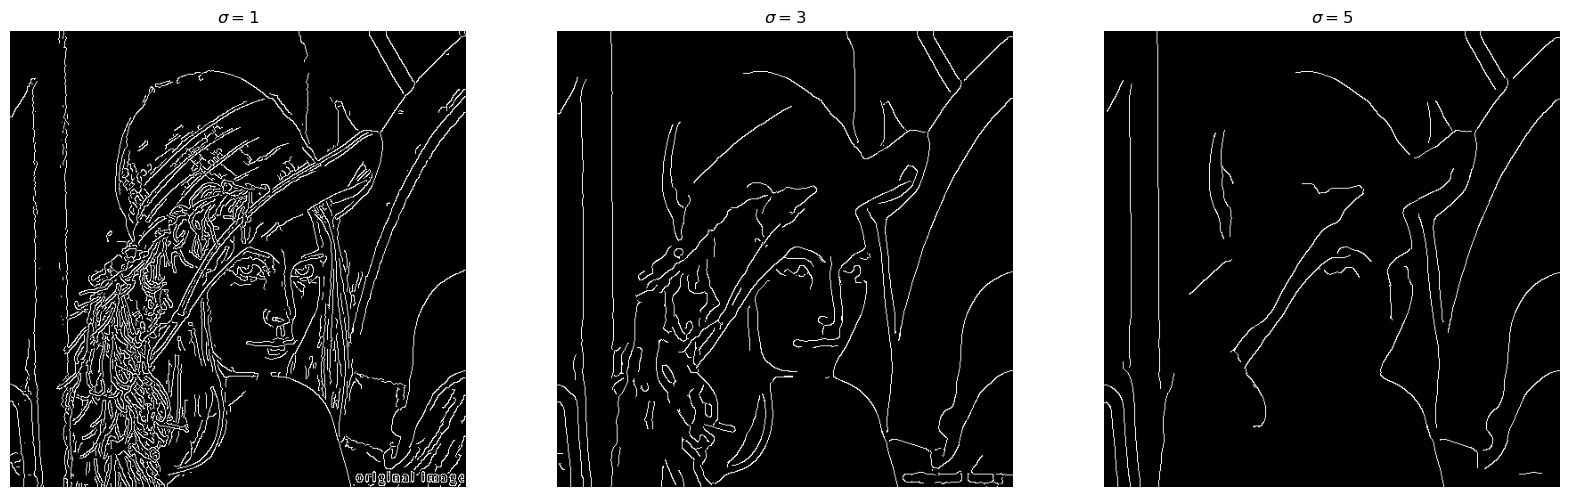

In [37]:
# img1 je lena.tif
edges1 = canny_edge_detection(img1, 1, 0.2, 0.1)
print(f'Gotova prva detekcija')
edges2 = canny_edge_detection(img1, 3, 0.2, 0.1)
print(f'Gotova druga detekcija')
edges3 = canny_edge_detection(img1, 5, 0.2, 0.1)
print(f'Gotova treca detekcija')

# Prikaz
plt.figure(figsize=(20,10));
plt.subplot(131); plt.imshow(edges1, cmap='gray'); plt.title('$\sigma = 1$'); plt.axis('off');
plt.subplot(132); plt.imshow(edges2, cmap='gray'); plt.title('$\sigma = 3$'); plt.axis('off');
plt.subplot(133); plt.imshow(edges3, cmap='gray'); plt.title('$\sigma = 5$'); plt.axis('off');

2. **VARIRANJE PRAGOVA**

Za fiksirano sigma, pragovi nam određuju opseg u kom detektujemo ivice. Da bismo idealno odabrali pragove, potrebno je pogledati **međurezultat 2.5.** nakon potiskivanja lokalnih nemaksimuma. Tada nam magnitude preostalih piksela ukazuju na opseg u kom bi bilo idealno detektovati. 

**Povećanjem pragova** se smanjuje broj ivica koje se detektuju, a **smanjenjem pragova** povećava broj ivica

Gotova prva detekcija
Gotova druga detekcija
Gotova treca detekcija


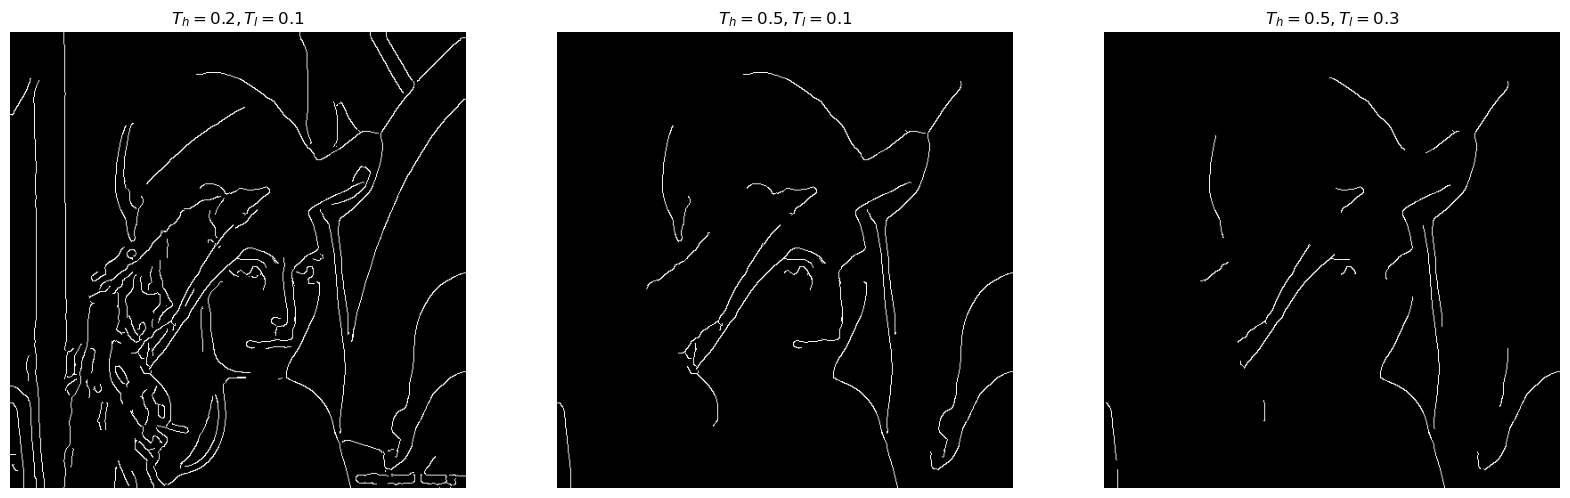

In [38]:
edges1 = canny_edge_detection(img1, 3, 0.2, 0.1)
print(f'Gotova prva detekcija')
edges2 = canny_edge_detection(img1, 3, 0.5, 0.1)
print(f'Gotova druga detekcija')
edges3 = canny_edge_detection(img1, 3, 0.5, 0.3)
print(f'Gotova treca detekcija')

# Prikaz
plt.figure(figsize=(20,10));
plt.subplot(131); plt.imshow(edges1, cmap='gray'); plt.title('$T_h = 0.2, T_l = 0.1$'); plt.axis('off');
plt.subplot(132); plt.imshow(edges2, cmap='gray'); plt.title('$T_h = 0.5, T_l = 0.1$'); plt.axis('off');
plt.subplot(133); plt.imshow(edges3, cmap='gray'); plt.title('$T_h = 0.5, T_l = 0.3$'); plt.axis('off');

## 2.10. Prikaz rada funkcije: Podeseni parametri za 3 slike

**Komentar o izboru parametara**:

Varirao sam parametre u međukoracima od 2.1. do 2.8. za sve tri slike. Parametre sam birao na sledeći način:

**Pragove** sam birao na osnovu međurezultata 2.5. tako da se ivice od interesa detektuju.

**Sigma** sam birao za drugačije za svaku sliku. 

Za *lenu.tif* sam želeo da se ne detektuje previše ivica u perju na šeširu. Zato sam odabrao veće sigma da bi potisnuo više učestanosti na perju i ostavio samo par ivica tu. 

Za *van.tif* sam odabrao manje sigma nego za lenu, zato što je ova slika već zamućenija od lene i nema puno visokih učestanosti niti šuma. Obratiti pažnju da je ova slika sličnih dimenzija kao lena.

Za *Camerman.tif* sam odabrao još manje sigma. Ovo je zato što je slika manjih dimenzija od prethodne dve. Dakle, iako je sigma manje nego prethodne dve slike, želeo sam da više potisnem šum nego u prethodne dve. Odabrano sigma se pokazalo kao dovoljno veliko sigma da potisne šum, a zatim sam pomoću pragova odabrao da se detektuju ivice koje nisu posledica šuma.

Gotova prva detekcija
Gotova druga detekcija
Gotova treca detekcija


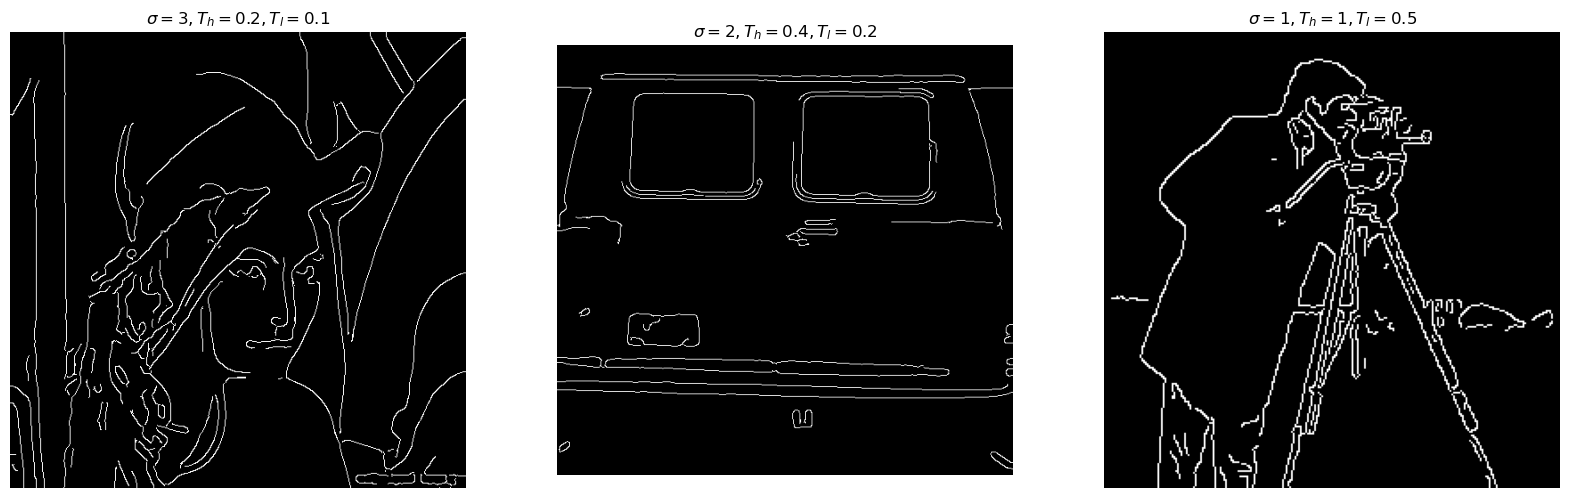

In [39]:
edges1 = canny_edge_detection(img1, 3, 0.2, 0.1)
print(f'Gotova prva detekcija')
edges2 = canny_edge_detection(img2, 2, 0.4, 0.2)
print(f'Gotova druga detekcija')
edges3 = canny_edge_detection(img3, 1, 0.8, 0.6)
print(f'Gotova treca detekcija')

# Prikaz
plt.figure(figsize=(20,10));
plt.subplot(131); plt.imshow(edges1, cmap='gray'); plt.title('$\sigma = 3, T_h = 0.2, T_l = 0.1$'); plt.axis('off');
plt.subplot(132); plt.imshow(edges2, cmap='gray'); plt.title('$\sigma = 2, T_h = 0.4, T_l = 0.2$'); plt.axis('off');
plt.subplot(133); plt.imshow(edges3, cmap='gray'); plt.title('$\sigma = 1, T_h = 1, T_l = 0.5$'); plt.axis('off');